## FROM  NAIVE BAYES TO BERT: A MULTI-MODEL APPROACH TO SENTIMENT ANALYSIS ON THE IMDB MOVIE REVIEW DATASET.

 1. IMPORTING AND INSTALLING THE NECESSARY LIBRARIES

In [1]:
# Installing Natural Language Toolkit,a popular Python library for working with human language data (text).
!pip install nltk  

In [2]:
# Running !python -m spacy download en_core_web_sm to download the pre-trained lemmatization model.
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     -------------------- ------------------- 6.6/12.8 MB 26.8 MB/s eta 0:00:01
     ---------------------------------- ---- 11.3/12.8 MB 24.9 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 21.5 MB/s  0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot') # for better readability of the plots
import seaborn as sns
import re
import os
import sys
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import gensim
import spacy
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from gensim.parsing.preprocessing import STOPWORDS
import gensim.models.phrases
from gensim.models.phrases import Phraser

nltk.download('stopwords') # Downloading NLTK data
stop_words = set(stopwords.words('english'))
print("Libraries imported successfully.")

Libraries imported successfully.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2. LOADING DATA AND EXPLORATORY DATA ANALYSIS (EDA) OF THE RAW IMDB DATA.

In [4]:
# EDA on raw IMDB reviews helps me see the noise and structure of the data before cleaning. 
df_imdb = pd.read_csv('IMDB Dataset.csv') # Loading Dataset 
df_imdb # Displaying the Dataset

review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]

In [5]:
print(f"Dataset Shape: {df_imdb.shape}") # To know size of the raw dataset, the number of rows and columns

Dataset Shape: (50000, 2)


In [6]:
df_imdb.describe() # Summarizing the statistics of the raw IMDB Dataset generally. 

review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

In [7]:
# visualizing the Descriptive Statistics of the raw IMDB Data
df_imdb['len'] = df_imdb['review'].apply(lambda x: len(x.split()))
print(df_imdb['len'].describe())

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: len, dtype: float64


In [8]:
# count    50000.000000
# mean       231.156940   Average review is approximately 231 words
# std        171.343997
# min          4.000000   Shortest review is 4 words
# 25%        126.000000
# 50%        173.000000   Median (Half are shorter than this)
# 75%        280.000000   75% of reviews are shorter than 280 words
# max       2470.000000   The longest review is huge (2470 words)

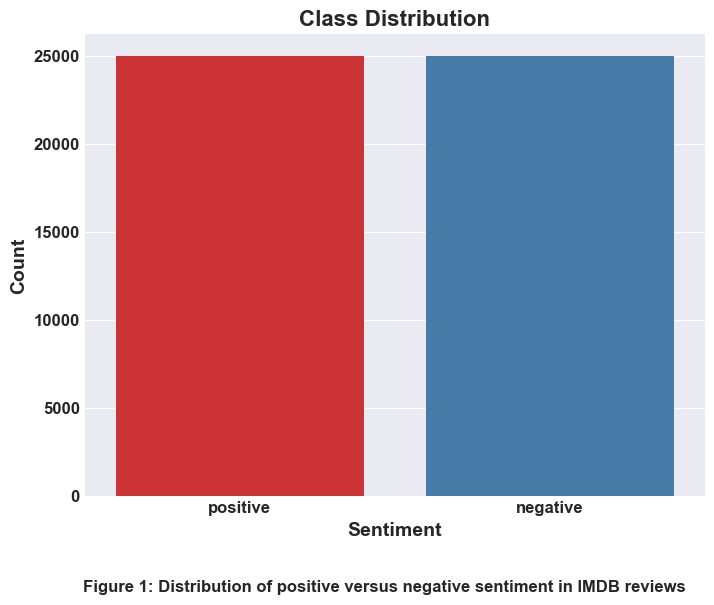

In [9]:
# Plotting Class Distribution of the Sentiment
# Checking if the Positive class is balanced with the negative class in the Sentiment
plt.style.use('seaborn-v0_8-darkgrid') # To make the style bold

plt.figure(figsize=(8,6)) # Making the figure clear

sns.countplot(x=df_imdb['sentiment'], hue = df_imdb['sentiment'], palette="Set1") # Creating the countplot with bold colors

plt.title('Class Distribution', fontsize=16, fontweight='bold') # Adding a bold title to the plot
# Labelling axes clearly
plt.xlabel('Sentiment', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')

# Making tick labels larger and bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding caption below the plot
plt.figtext(0.5, -0.05, 
            "Figure 1: Distribution of positive versus negative sentiment in IMDB reviews", 
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the figure with high resolution to use in my report
plt.savefig("class_distribution.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

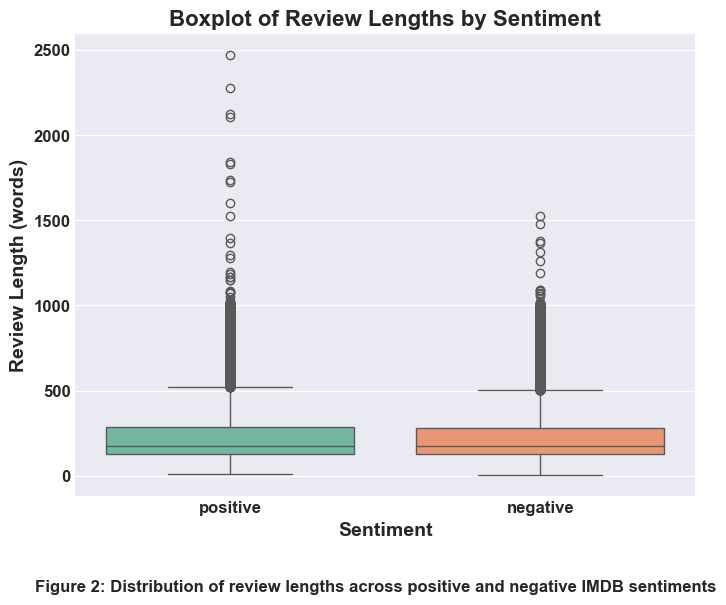

In [10]:
# PLotting Box Plot for the reviews
# Creating 'review_length' column (number of words per review)
df_imdb['review_length'] = df_imdb['review'].apply(lambda x: len(str(x).split()))


# Creating the figure
plt.figure(figsize=(8,6))

# Boxplot grouped by sentiment
sns.boxplot(x='sentiment', y='review_length', data=df_imdb, hue = 'sentiment', palette="Set2")

# Adding bold title and axis labels
plt.title('Boxplot of Review Lengths by Sentiment', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment', fontsize=14, fontweight='bold')
plt.ylabel('Review Length (words)', fontsize=14, fontweight='bold')

# Adding Bold tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding Caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 2: Distribution of review lengths across positive and negative IMDB sentiments",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the figure
plt.savefig("boxplot_review_length.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

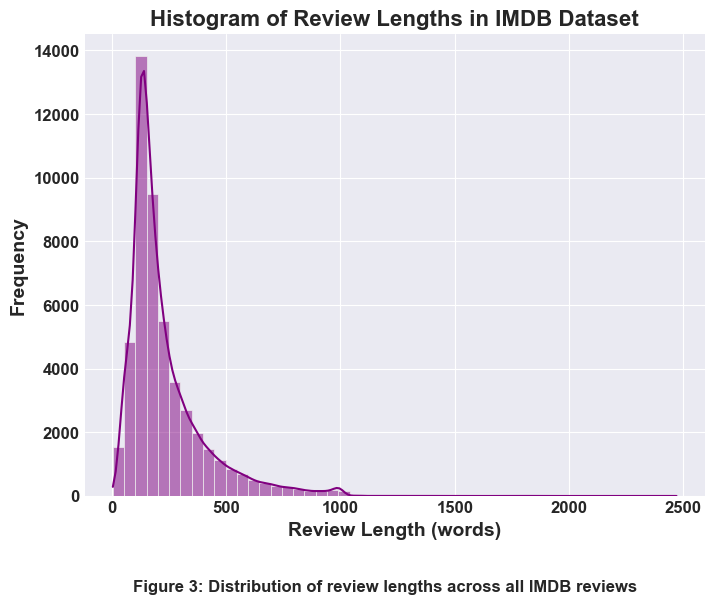

In [11]:
# Histogram plot of review length analysis
# Creating the figure
plt.figure(figsize=(8,6))

# Histogram of review lengths
sns.histplot(df_imdb['review_length'], bins=50, kde=True, color="purple")

# Adding bold title and axis labels
plt.title('Histogram of Review Lengths in IMDB Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Review Length (words)', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# Adding Bold tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding Caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 3: Distribution of review lengths across all IMDB reviews",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the figure
plt.savefig("histogram_review_length.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()


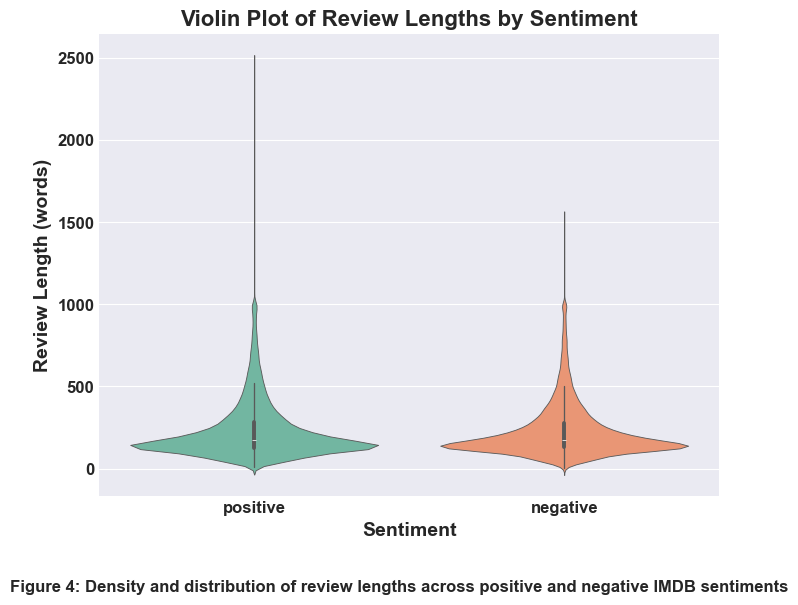

In [12]:
# Violin plot for density + distribution shape 
# Creating the figure
plt.figure(figsize=(8,6))

# Violin plot grouped by sentiment
sns.violinplot(x='sentiment', y='review_length', data=df_imdb, hue ='sentiment', palette="Set2")

# Adding bold title and axis labels
plt.title('Violin Plot of Review Lengths by Sentiment', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment', fontsize=14, fontweight='bold')
plt.ylabel('Review Length (words)', fontsize=14, fontweight='bold')

# Adding Bold tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding Caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 4: Density and distribution of review lengths across positive and negative IMDB sentiments",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the figure
plt.savefig("violinplot_review_length.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

In [13]:
#  Violin plot combines a boxplot with a kernel density estimate.  
# the median and quartiles(like a boxplot) plus the distribution shape (like a smoothed histogram).  
# This makes it easier to compare how review lengths vary between positive and negative classes.  

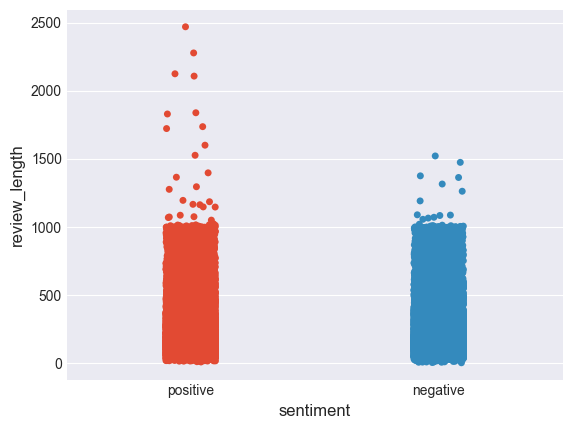

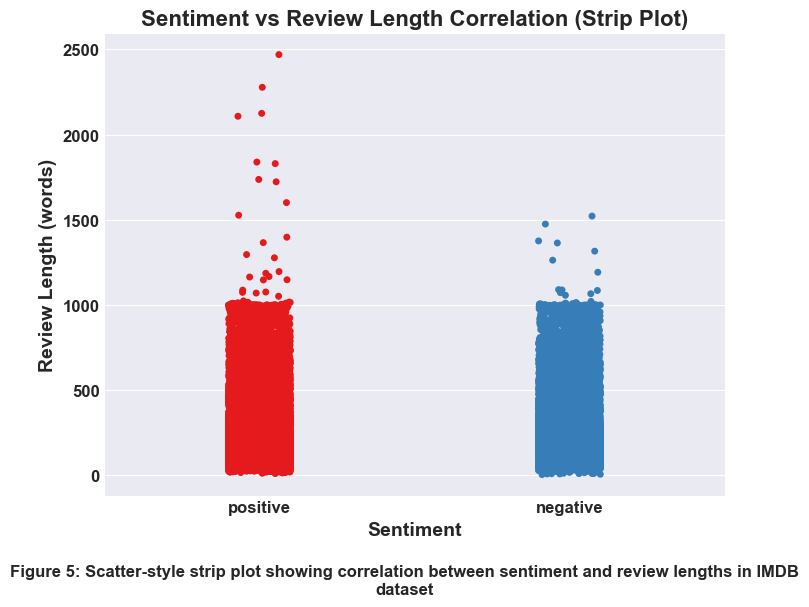

In [14]:
# Scatter-style strip plot of Sentiment versus Review Length Correlation with jitter for better visibility
sns.stripplot(x='sentiment', y='review_length', data=df_imdb, hue ='sentiment', jitter=True)

# Creating the figure
plt.figure(figsize=(8,6))

# Strip plot (scatter-like) grouped by sentiment
sns.stripplot(x='sentiment', y='review_length', data=df_imdb, hue ='sentiment', jitter=True, palette="Set1")

# Adding bold title and axis labels
plt.title('Sentiment vs Review Length Correlation (Strip Plot)', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment', fontsize=14, fontweight='bold')
plt.ylabel('Review Length (words)', fontsize=14, fontweight='bold')

# Adding Bold tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding Caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 5: Scatter-style strip plot showing correlation between sentiment and review lengths in IMDB dataset",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the figure
plt.savefig("stripplot_review_length.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

In [15]:
# This shows Each point = one review.  
# Jitter spreads points horizontally to avoid overlap.  
# It visually compares how review lengths vary between positive and negative classes.  

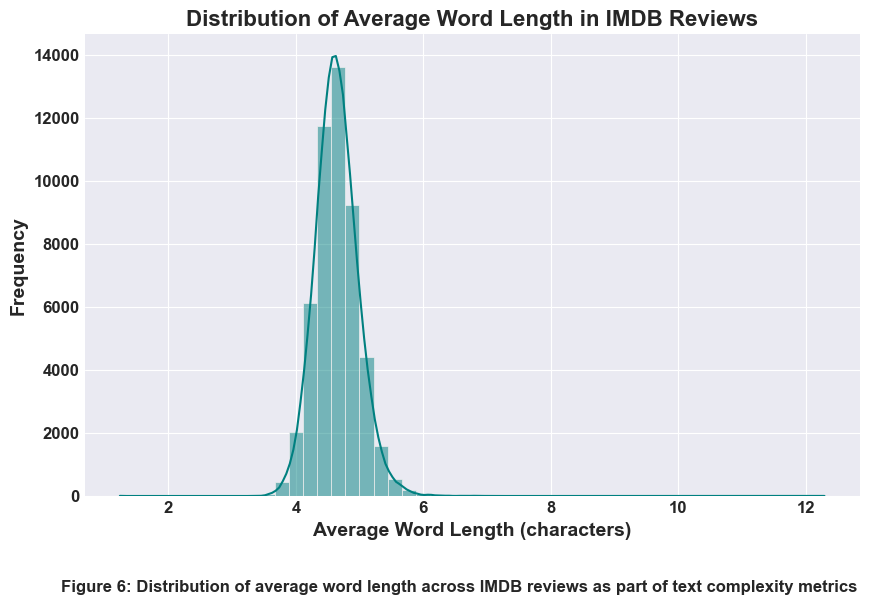

In [16]:
# Text Complexity Metrics:Average word length
# Average word length
df_imdb['avg_word_length'] = df_imdb['review'].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0)

# Creating the figure
plt.figure(figsize=(10,6))

# Histogram of average word length
sns.histplot(df_imdb['avg_word_length'], bins=50, kde=True, color="teal")

# Adding bold title and axis labels
plt.title('Distribution of Average Word Length in IMDB Reviews', fontsize=16, fontweight='bold')
plt.xlabel('Average Word Length (characters)', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# Adding Bold tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding Caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 6: Distribution of average word length across IMDB reviews as part of text complexity metrics",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the figure
plt.savefig("avg_word_length_distribution.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

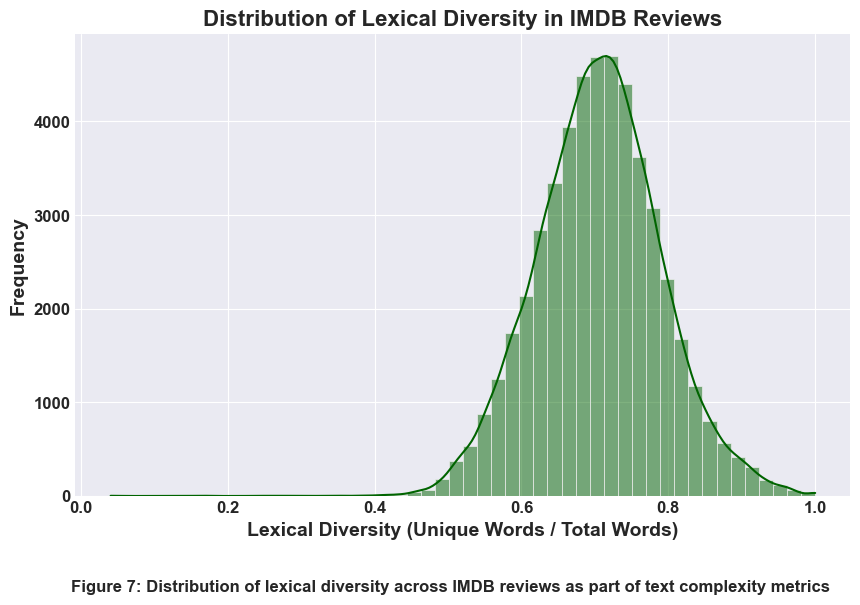

In [17]:
# Text Complexity Metrics:Lexical diversity (unique words / total words)
df_imdb['lexical_diversity'] = df_imdb['review'].apply(
    lambda x: len(set(str(x).split())) / len(str(x).split()) if len(str(x).split()) > 0 else 0
)

# Creating the figure
plt.figure(figsize=(10,6))

# Histogram of lexical diversity
sns.histplot(df_imdb['lexical_diversity'], bins=50, kde=True, color="darkgreen")

# Adding bold title and axis labels
plt.title('Distribution of Lexical Diversity in IMDB Reviews', fontsize=16, fontweight='bold')
plt.xlabel('Lexical Diversity (Unique Words / Total Words)', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# Adding Bold tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding Caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 7: Distribution of lexical diversity across IMDB reviews as part of text complexity metrics",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the figure
plt.savefig("lexical_diversity_distribution.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

In [18]:
# Lexical diversity = ratio of unique words to total words in each review.  
# Values closer to 1 reviews with more varied vocabulary.  
# Values closer to 0  reviews with repetitive or limited vocabulary.  

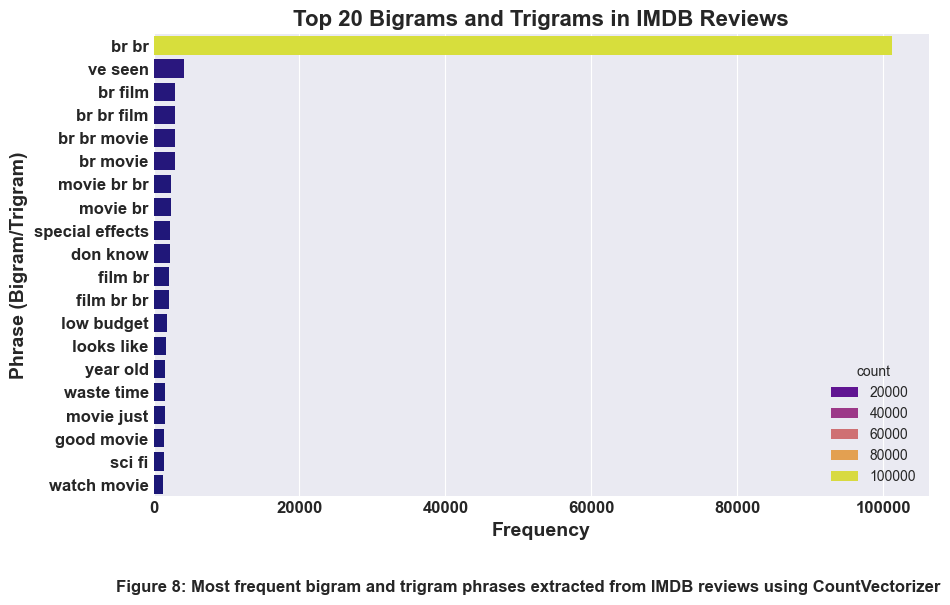

In [19]:
# Word Frequency and N-gram Analysis (Top bigrams and trigrams)
vectorizer = CountVectorizer(ngram_range=(2,3), stop_words='english')
X = vectorizer.fit_transform(df_imdb['review'])

# Summing up the counts of each token
word_counts = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

# Creating DataFrame of word frequencies
freq_df_imdb = pd.DataFrame({'phrase': words, 'count': word_counts})
freq_df_imdb = freq_df_imdb.sort_values(by='count', ascending=False).head(20)  # Top 20

# Creating the figure
plt.figure(figsize=(10,6))

# Barplot of top bigrams/trigrams
sns.barplot(x='count', y='phrase', data=freq_df_imdb, hue = 'count', palette="plasma")

# Adding bold title and axis labels
plt.title('Top 20 Bigrams and Trigrams in IMDB Reviews', fontsize=16, fontweight='bold')
plt.xlabel('Frequency', fontsize=14, fontweight='bold')
plt.ylabel('Phrase (Bigram/Trigram)', fontsize=14, fontweight='bold')

# Adding Bold tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding Caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 8: Most frequent bigram and trigram phrases extracted from IMDB reviews using CountVectorizer",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the figure
plt.savefig("top_bigrams_trigrams.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

In [20]:
# This uses CountVectorizer(ngram_range=(2,3)) to extracts bigrams and trigrams only.  
# Displaying aggregates counts and selects the Top 20 most frequent phrases.  
# Displaying them in a horizontal barplot 

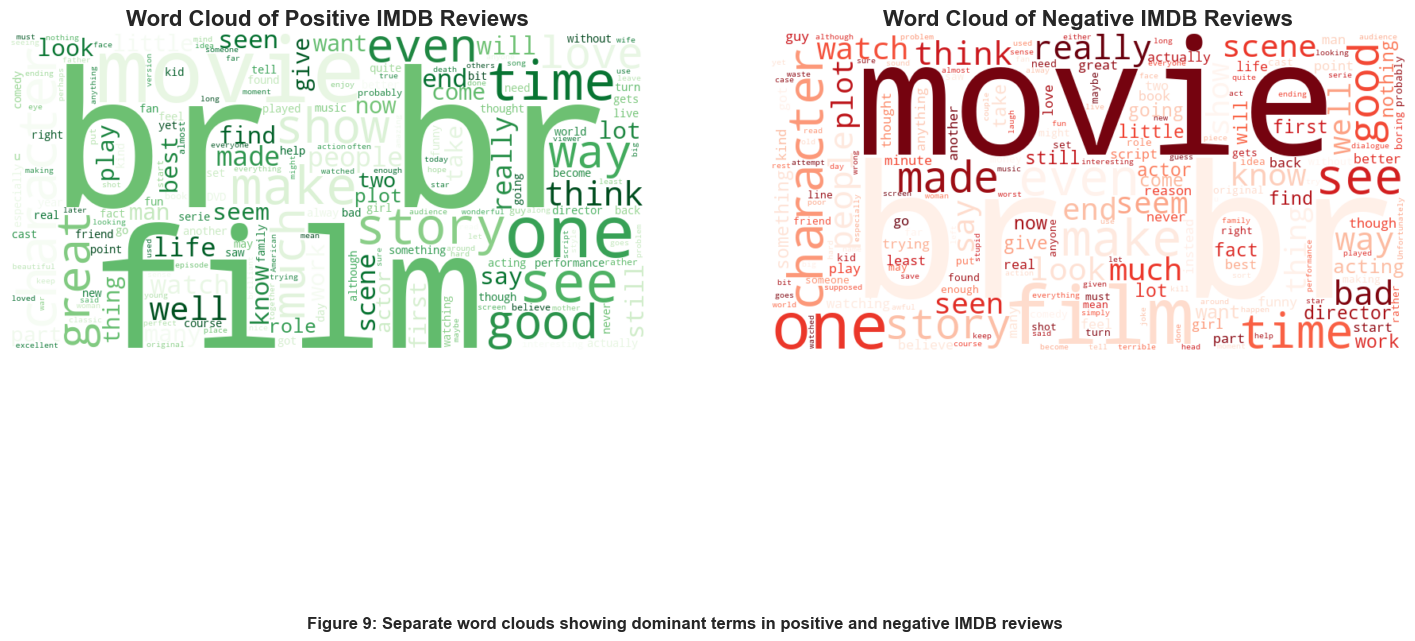

In [21]:
# Word Clouds- Separating clouds for positive and negative reviews to visualize dominant terms.

# Generating word cloud for positive reviews
positive_text = ' '.join(df_imdb[df_imdb['sentiment'] == 'positive']['review'])
positive_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)

# Generating word cloud for negative reviews
negative_text = ' '.join(df_imdb[df_imdb['sentiment'] == 'negative']['review'])
negative_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

# Creating the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18,8))

# Positive word cloud
axes[0].imshow(positive_wc, interpolation='bilinear')
axes[0].set_title('Word Cloud of Positive IMDB Reviews', fontsize=16, fontweight='bold')
axes[0].axis('off')

# Negative word cloud
axes[1].imshow(negative_wc, interpolation='bilinear')
axes[1].set_title('Word Cloud of Negative IMDB Reviews', fontsize=16, fontweight='bold')
axes[1].axis('off')

# Adding Caption below both plots
fig.text(0.5, -0.05,
         "Figure 9: Separate word clouds showing dominant terms in positive and negative IMDB reviews",
         ha='center', fontsize=12, fontweight='bold')

# Saving the figure
plt.savefig("wordclouds_sentiment.png", dpi=300, bbox_inches='tight')

# Showing the plots
plt.show()

In [22]:
# Positive reviews-green word cloud highlighting frequent positive terms.  
# Negative reviews-red word cloud highlighting frequent negative terms.  
# Side‑by‑side layout makes it easy to compare dominant vocabulary across sentiments.  

3. DATA CLEANING OF THE RAW IMDB DATA

In [23]:
# From the EDA of the raw IMDB Data done, I discovered Skewed Feature Distribution,Noise & Redundancy,Inconsistent Vocabulary,and Misleading Characters,
# which is why the IMDB data need to be cleaned and prepared for the models. 

In [24]:
print(df_imdb.isnull().sum()) # To check for Missing values in the Data

review               0
sentiment            0
len                  0
review_length        0
avg_word_length      0
lexical_diversity    0
dtype: int64


In [25]:
# No Missing value seen

In [26]:
print(f"Duplicates: {df_imdb.duplicated().sum()}") # Checking for duplicated reviews

Duplicates: 418


In [27]:
# Duplicated reviews are 418
df_imdb.drop_duplicates(inplace=True) # To remove duplicated Reviews

In [28]:
print(f"Duplicates: {df_imdb.duplicated().sum()}") # # Rechecking for duplicated reviews

Duplicates: 0


In [29]:
# Checking the class label consistency
print(df_imdb['sentiment'].unique())

['positive' 'negative']


In [30]:
def clean_text_v2(text):
    """
    Performs Lowercasing, HTML Tag Removal, Text Normalization, and Punctuation/Symbol Removal.

    Args:
        text (str): The raw text review.

    Returns:
        str: The cleaned text ready for further tokenization/analysis.
    """
    
    # Converting all text to lowercase.
    text = text.lower()
    
    # HTML Tag Removal and Text Normalization.
    # HTML Tag Removal (Handles <br />, <b>, </i>,)
    text = re.sub(r'<.*?>', ' ', text)
    
    # Newline/Tab Removal (Replace with space to prevent words from joining)
    text = re.sub(r'\n|\t|\r', ' ', text)
    
    # Removing all punctuation,special characters and non-alphabetic characters.
    # Replacing any character that is NOT a letter (a-z) with a single space.
    text = re.sub(r'[^a-z]', ' ', text)
    
    # Removing extra spaces caused by the cleaning process
    text = re.sub(r'\s+', ' ', text).strip()
    
    # The resulting text is a single string. 
    return text

# Applying string cleaning
df_imdb['cleaned_review_string'] = df_imdb['review'].apply(clean_text_v2)

In [31]:
# displaying the cleaned review string
print(df_imdb['cleaned_review_string'].head())

0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically there s a family where a little boy ...
4    petter mattei s love in the time of money is a...
Name: cleaned_review_string, dtype: object


In [32]:
clean_data = df_imdb['cleaned_review_string'].tolist() # Converting the clean strings to a list
clean_data[:3] # Displaying just the first 3 of this list

['one of the other reviewers has mentioned that after watching just oz episode you ll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows wouldn t dare forget pretty 

In [33]:
# Tokenization (Input Clean string list ,and  Output List of lists of words)
# Simple_preprocess to effectively handle tokenization and basic cleaning
def change_to_words(sentences):
    # simple_preprocess tokenizes, lowercases, and removes single-character tokens (default min_len=2)
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=False)) # deacc=False to preserve accents if any
# Applying the function 
data_words = list(change_to_words(clean_data))         

In [34]:
# Displaying the first clean list tokenized 
data_words[:1]

[['one',
  'of',
  'the',
  'other',
  'reviewers',
  'has',
  'mentioned',
  'that',
  'after',
  'watching',
  'just',
  'oz',
  'episode',
  'you',
  'll',
  'be',
  'hooked',
  'they',
  'are',
  'right',
  'as',
  'this',
  'is',
  'exactly',
  'what',
  'happened',
  'with',
  'me',
  'the',
  'first',
  'thing',
  'that',
  'struck',
  'me',
  'about',
  'oz',
  'was',
  'its',
  'brutality',
  'and',
  'unflinching',
  'scenes',
  'of',
  'violence',
  'which',
  'set',
  'in',
  'right',
  'from',
  'the',
  'word',
  'go',
  'trust',
  'me',
  'this',
  'is',
  'not',
  'show',
  'for',
  'the',
  'faint',
  'hearted',
  'or',
  'timid',
  'this',
  'show',
  'pulls',
  'no',
  'punches',
  'with',
  'regards',
  'to',
  'drugs',
  'sex',
  'or',
  'violence',
  'its',
  'is',
  'hardcore',
  'in',
  'the',
  'classic',
  'use',
  'of',
  'the',
  'word',
  'it',
  'is',
  'called',
  'oz',
  'as',
  'that',
  'is',
  'the',
  'nickname',
  'given',
  'to',
  'the',
  'oswald

In [35]:
# Generating the bigrams and trigrams to help capture word context and multi‑word expressions that single words missed.
# Training the Bigram Model
# The Phraser object learns common two-word phrases.
bigram = gensim.models.phrases.Phrases(data_words, min_count=5, threshold=100)

In [36]:
# bigram[data_words] is used to generate the bigram-transformed text 
bigram[data_words]

In [37]:
# Training the Trigram Model 
# The input for the Trigram model is the data_words processed by the Bigram model.
# for the Trigram model to learn three-word phrases from.
trigram = gensim.models.phrases.Phrases(bigram[data_words], threshold=100)

In [38]:
# Creating the Phraser Objects for faster application
# This Converts the Phrases model (bigram)to a Phraser object for faster subsequent application.
# This replaces the need for bigram[data_words] lines that produce disposable generators.
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [39]:
# Creating the Phraser Objects for faster application
# This Converts the Phrases model (trigram)to a Phraser object for faster subsequent application.
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [40]:
# For bigram
# Converting keys to a list and slice the first 20
first_20_bigrams = list(bigram_mod.phrasegrams.keys())[:20]

# Printing them one by one
for bigram in first_20_bigrams:
    print(bigram)

faint_hearted
maximum_security
graphic_violence
middle_class
darker_side
air_conditioned
light_hearted
serial_killer
woody_allen
wears_prada
soap_opera
visually_stunning
new_york
steve_buscemi
rosario_dawson
carol_kane
michael_imperioli
paul_lukas
bette_davis
mildly_entertaining


In [41]:
# For trigram
# Converting keys to a list and slice the first 20
first_20_trigrams = list(trigram_mod.phrasegrams.keys())[:20]

# Printing them one by one
for trigram in first_20_trigrams:
    print(trigram)

faint_hearted
maximum_security
graphic_violence
middle_class
darker_side
michael_sheen
air_conditioned
light_hearted
serial_killer
woody_allen
wears_prada
devil_wears_prada
soap_opera
visually_stunning
new_york
steve_buscemi
rosario_dawson
carol_kane
michael_imperioli
paul_lukas


In [42]:
# Lemmatisation and Stopwords
# Adding my own stop word
my_stop_words = STOPWORDS.union(set(['br']))

In [43]:
# Creating a function to remove stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in my_stop_words] for doc in texts]

In [44]:
# Applying the remove_stopwords function
# creating a cleaned version of the IMDB reviews with stopwords removed
data_words_no_stops = remove_stopwords(data_words)

In [45]:
# Creating a functions transform tokenized text into bigram and trigram phrases again for the data_words_no_stops
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [46]:
# Applying the function
data_words_bigrams = make_bigrams(data_words_no_stops)
data_words_trigrams = make_trigrams(data_words_no_stops)

In [47]:
# Printing the first 10 bigrams
bigrams_list = []

for i, text in enumerate(data_words_bigrams):
    for word in text:
        if "_" in word:        # identifies trigram tokens (joined with underscores)
            bigrams_list.append((i, word))

# Print only the first 10
for item in bigrams_list[:10]:
    print(item)

(0, 'faint_hearted')
(0, 'maximum_security')
(0, 'graphic_violence')
(0, 'middle_class')
(2, 'air_conditioned')
(2, 'light_hearted')
(2, 'serial_killer')
(2, 'woody_allen')
(2, 'wears_prada')
(3, 'soap_opera')


In [48]:
# Printing the first 10 trigrams
trigrams_list = []

for i, text in enumerate(data_words_trigrams):
    for word in text:
        if "_" in word:   # identifies trigram tokens (joined with underscores)
            trigrams_list.append((i, word))

# Print only the first 10
for item in trigrams_list[:10]:
    print(item)

(0, 'faint_hearted')
(0, 'maximum_security')
(0, 'graphic_violence')
(0, 'middle_class')
(1, 'michael_sheen')
(2, 'air_conditioned')
(2, 'light_hearted')
(2, 'serial_killer')
(2, 'woody_allen')
(2, 'devil_wears_prada')


In [49]:
# Initializing spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [50]:
# Creating a function to remove stopwords and lemmatize
def no_stop_words_and_lemmatize(texts, my_stop_words, allowed_postags=['NOUN','ADJ','VERB','ADV']):
    """ https://spacy.io/api/annotation,Lemmatizes tokenized texts with spaCy, keeping only allowed parts of speech."""
    texts_out = []
    for sent in texts:
        # Removing stopwords + split underscores into separate words
        filtered = []
        for word in simple_preprocess(str(sent)):
            if word not in my_stop_words:
                # split on underscores 
                filtered.extend(word.split('_'))
        
        # Re-joining words for SpaCy's efficient pipeline processing
        doc = nlp(" ".join(filtered))
        
        # Lemmatizing and filtering by POS tag
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [51]:
my_stop_words = []
# Applying lemmatization keeping only noun, adj, vb, adv
data_lemmatized = no_stop_words_and_lemmatize(
    data_words_trigrams, 
    my_stop_words, 
    allowed_postags=['NOUN','ADJ','VERB','ADV']
)

In [52]:
# Printing the first lemmatized document (a list of tokens) from `data_lemmatized`.
print('data_lemmatized[:1]', data_lemmatized[:1])

data_lemmatized[:1] [['reviewer', 'mention', 'watch', 'episode', 'hook', 'right', 'exactly', 'happen', 'thing', 'strike', 'brutality', 'unflinche', 'scene', 'violence', 'set', 'right', 'word', 'trust', 'faint', 'hearted', 'timid', 'pull', 'punch', 'regard', 'drug', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'call', 'give', 'oswald', 'state', 'focus', 'mainly', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inward', 'privacy', 'high', 'agenda', 'city', 'home', 'aryan', 'italian', 'irish', 'scuffle', 'death', 'stare', 'dodgy', 'dealing', 'shady', 'agreement', 'far', 'away', 'main', 'appeal', 'fact', 'go', 'show', 'dare', 'forget', 'pretty', 'picture', 'paint', 'mainstream', 'audience', 'forget', 'charm', 'forget', 'romance', 'mess', 'episode', 'see', 'strike', 'nasty', 'surreal', 'couldn', 'ready', 'watch', 'develop', 'taste', 'get', 'accustomed', 'high', 'level', 'violence', 'injustice', 'crooked', 'guard', 'sell', 'nickel', 'inmate', 'kill', 'order', 'away', 'man

In [53]:
# Converting each lemmatized document (a list of tokens) into a single string by joining the words with spaces and stores all those strings in the list strings
strings = []
for l in data_lemmatized:
    t = ' '.join(l)
    strings.append(t)

4. EXPLORATORY DATA ANALYSIS(EDA) OF THE CLEANED IMDB DATASET

In [54]:
# visually the Statistics of the Clean IMDB Dataset
# Calculating length of each document in terms of word count
doc_lengths = [len(doc.split()) for doc in strings]

# Basic statistics
total_docs = len(strings)
mean_length = np.mean(doc_lengths)
std_length = np.std(doc_lengths)
min_length = np.min(doc_lengths)
max_length = np.max(doc_lengths)
percentiles = np.percentile(doc_lengths, [25, 50, 75])

# Printing Statistics summary
print("Cleaned IMDB Reviews Statistics:")
print(f"Total documents: {total_docs}")
print(f"Mean length: {mean_length:.2f} words")
print(f"Standard deviation: {std_length:.2f}")
print(f"Minimum length: {min_length} words")
print(f"25th percentile: {percentiles[0]:.0f} words")
print(f"Median (50th percentile): {percentiles[1]:.0f} words")
print(f"75th percentile: {percentiles[2]:.0f} words")
print(f"Maximum length: {max_length} words")

Cleaned IMDB Reviews Statistics:
Total documents: 49582
Mean length: 87.37 words
Standard deviation: 66.38
Minimum length: 2 words
25th percentile: 46 words
Median (50th percentile): 65 words
75th percentile: 106 words
Maximum length: 990 words


In [55]:
# count    49582.000000  This has reduced from 50000.
# mean       87.37 words   
# std         66.38     
# min          2 words  Shortest review is 2 words.This has reduced
# 25%        46 words   
# 50%        65 words    
# 75%        106 words   75% of reviews are shorter than 106 words.
# max       990 words The longest review is 990 words.
# Compared to the Statistics of the raw IMDB reviews,the statistics of the Clean reviews has reduced

In [56]:
# Mapping sentiment to 0 (negative) and 1 (positive)
df_imdb['target'] = df_imdb['sentiment'].map({'positive': 1, 'negative': 0})

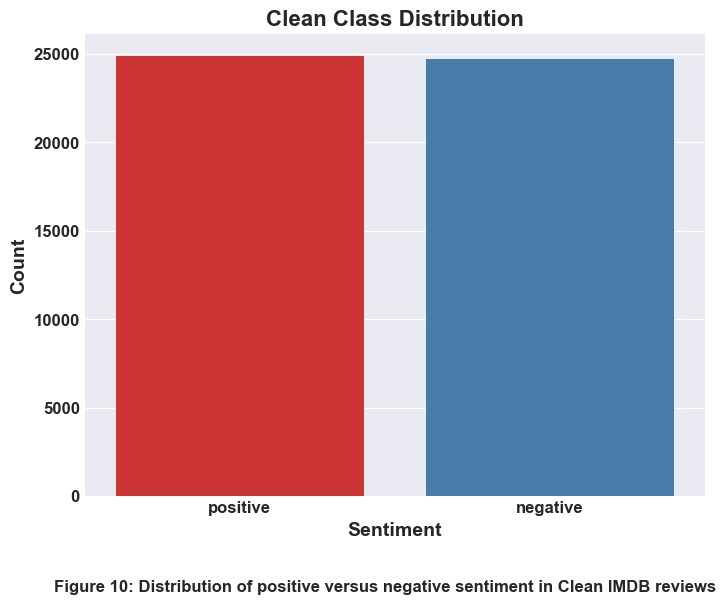

In [57]:
# Re-Checking if the Positive class is balanced with the negative class in the cleaned reviews
plt.style.use('seaborn-v0_8-darkgrid') # To make the style bold

plt.figure(figsize=(8,6)) # Making the figure clear

sns.countplot(x=df_imdb['sentiment'], hue = df_imdb['sentiment'], palette="Set1") # Creating the countplot with bold colors

plt.title('Clean Class Distribution', fontsize=16, fontweight='bold') # Adding a bold title to the plot
# Labelling axes clearly
plt.xlabel('Sentiment', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')

# Making tick labels larger and bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding caption below the plot
plt.figtext(0.5, -0.05, 
            "Figure 10: Distribution of positive versus negative sentiment in Clean IMDB reviews", 
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the figure with high resolution to use in my report
plt.savefig("clean_class_distribution.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

In [58]:
# Checking class count for the cleaned IMDB review data
class_counts = df_imdb['sentiment'].value_counts()

print("Clean Class distribution:")
print(class_counts)

# Calculating the percentage distribution of the Sentiment
print("\nPercentage distribution:")
print((class_counts / class_counts.sum()) * 100)

Clean Class distribution:
sentiment
positive    24884
negative    24698
Name: count, dtype: int64

Percentage distribution:
sentiment
positive    50.187568
negative    49.812432
Name: count, dtype: float64


In [59]:
# As can be seen in the plot the positive class numbers are almost the same as the negative class numbers so no need for data augmentation
# and the numbers have also reduced below that of the raw IMDB Dataset

In [60]:
# To get insights I will be generating all the plots again for the cleaned IMDB Data as done for the raw IMDB Dataset.

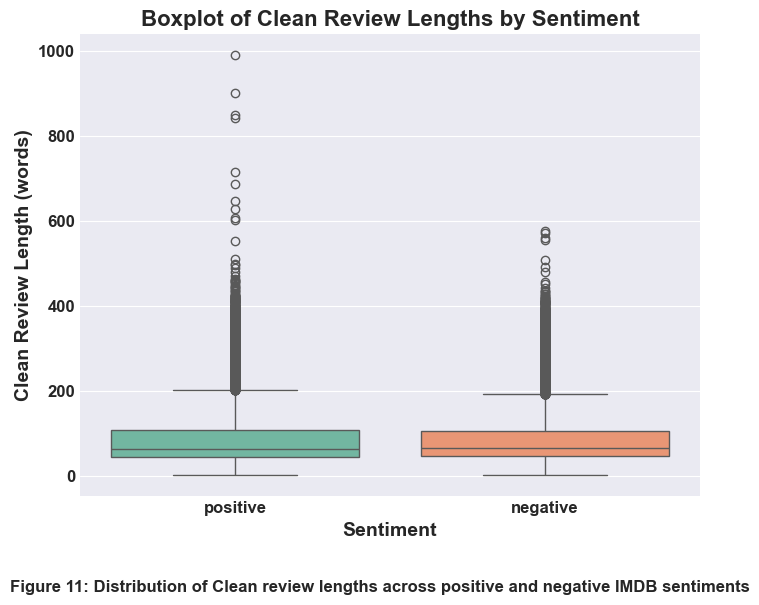

In [61]:
# PLotting Box Plot for the Clean reviews leghth
# Integrating the new list of strings (strings) back into your DataFrame (df_imdb)
# Assuming the length of 'strings' matches the length of df_imdb.
df_imdb['cleaned_review'] = strings

# Creating 'clean_review_length' column (number of words per review)
df_imdb['clean_review_length'] = df_imdb['cleaned_review'].apply(lambda x: len(str(x).split()))


# Creating the figure
plt.figure(figsize=(8,6))

# Boxplot grouped by sentiment
sns.boxplot(x='sentiment', y='clean_review_length', data=df_imdb,hue='sentiment', palette="Set2")

# Adding bold title and axis labels
plt.title('Boxplot of Clean Review Lengths by Sentiment', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment', fontsize=14, fontweight='bold')
plt.ylabel('Clean Review Length (words)', fontsize=14, fontweight='bold')

# Adding Bold tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding Caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 11: Distribution of Clean review lengths across positive and negative IMDB sentiments",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the figure
plt.savefig("boxplot_clean_review_length.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

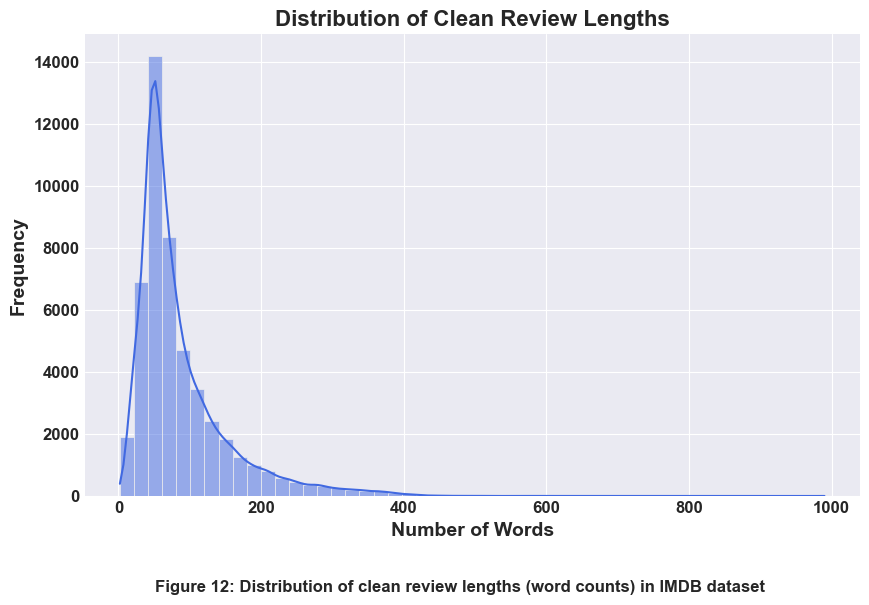

In [62]:
# Plotting Histogram to checking Review Length Distribution

plt.figure(figsize=(10,6))  # Clear figure size

# Histogram with bold colors
sns.histplot(df_imdb['clean_review_length'], bins=50, kde=True, color="royalblue")

# Adding bold title and labels
plt.title('Distribution of Clean Review Lengths', fontsize=16, fontweight='bold')
plt.xlabel('Number of Words', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# Making tick labels larger and bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding caption to the plot
plt.figtext(0.5, -0.05,
            "Figure 12: Distribution of clean review lengths (word counts) in IMDB dataset",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving figure with high resolution for report
plt.savefig("clean_review_length_distribution.png", dpi=300, bbox_inches='tight')

# Displaying  the plot
plt.show()

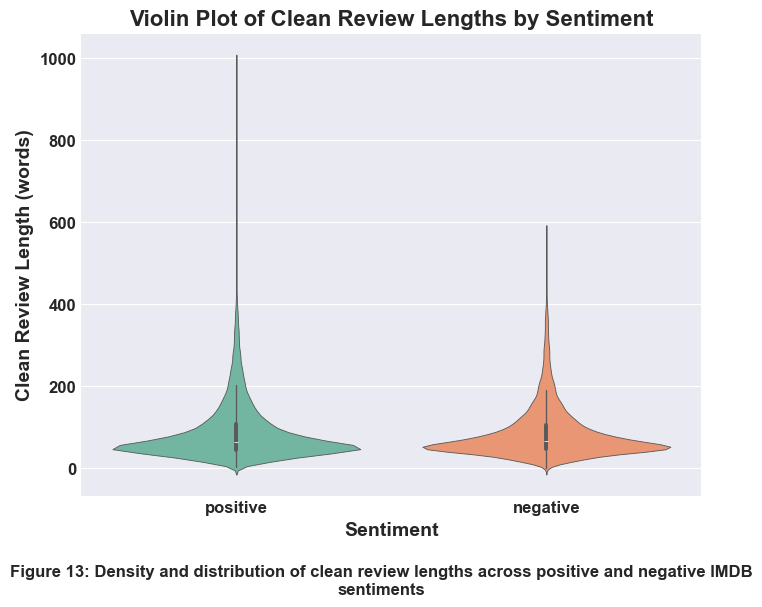

In [63]:
# Violin plot for density + distribution shape in the clean reviews
# Creating the figure
plt.figure(figsize=(8,6))

# Violin plot grouped by sentiment
sns.violinplot(x='sentiment', y='clean_review_length', data=df_imdb, hue='sentiment', palette="Set2")

# Adding bold title and axis labels
plt.title('Violin Plot of Clean Review Lengths by Sentiment', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment', fontsize=14, fontweight='bold')
plt.ylabel('Clean Review Length (words)', fontsize=14, fontweight='bold')

# Adding Bold tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding Caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 13: Density and distribution of clean review lengths across positive and negative IMDB sentiments",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the figure
plt.savefig("violinplot_clean_review_length.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

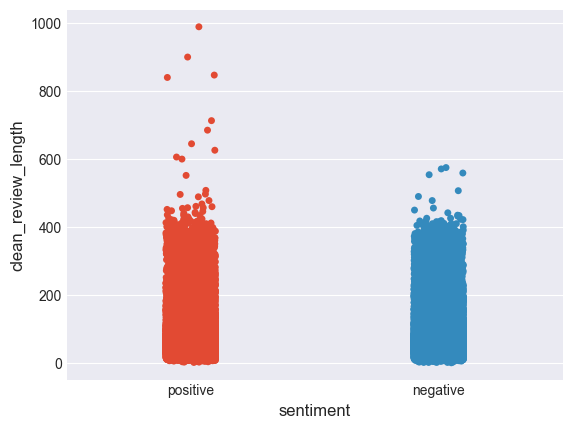

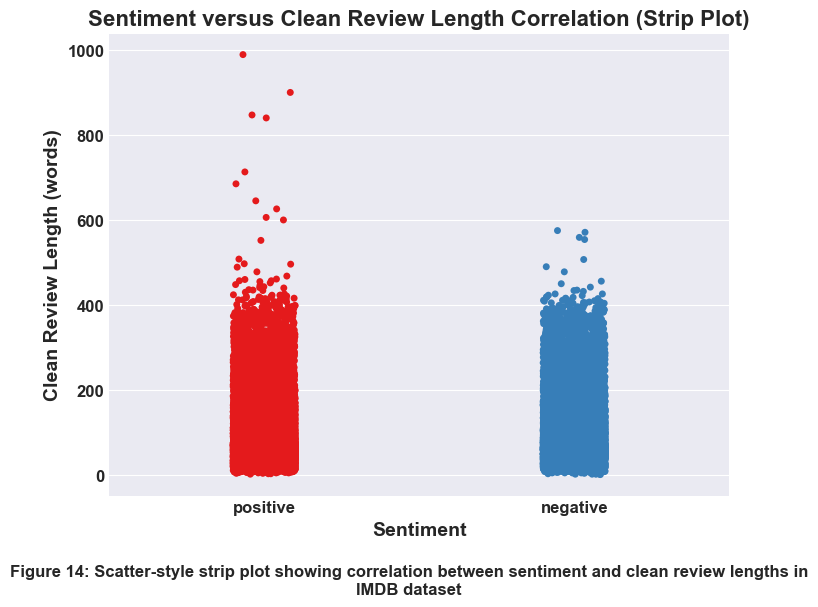

In [64]:
# Scatter-style strip plot of Sentiment versus Clean Review Length Correlation with jitter for better visibility
sns.stripplot(x='sentiment', y='clean_review_length', data=df_imdb, hue ='sentiment', jitter=True)

# Creating the figure
plt.figure(figsize=(8,6))

# Strip plot (scatter-like) grouped by sentiment
sns.stripplot(x='sentiment', y='clean_review_length', data=df_imdb, hue ='sentiment', jitter=True, palette="Set1")

# Adding bold title and axis labels
plt.title('Sentiment versus Clean Review Length Correlation (Strip Plot)', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment', fontsize=14, fontweight='bold')
plt.ylabel('Clean Review Length (words)', fontsize=14, fontweight='bold')

# Adding Bold tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding Caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 14: Scatter-style strip plot showing correlation between sentiment and clean review lengths in IMDB dataset",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the figure
plt.savefig("stripplot_clean_review_length.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

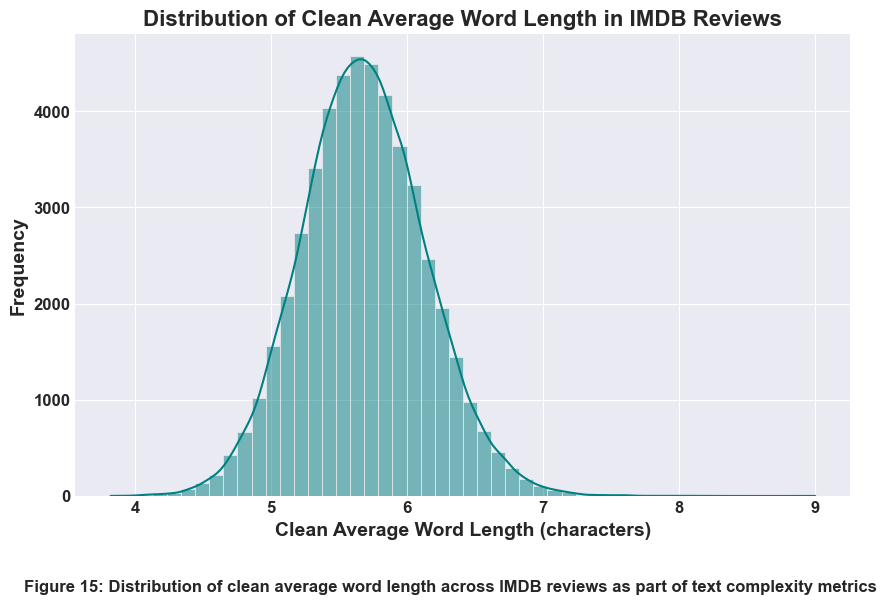

In [65]:
# Text Complexity Metrics:Clean average word length 
df_imdb['clean_avg_word_length'] = df_imdb['cleaned_review'].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0)

# Creating the figure
plt.figure(figsize=(10,6))

# Histogram of clean average word length
sns.histplot(df_imdb['clean_avg_word_length'], bins=50, kde=True, color="teal")

# Adding bold title and axis labels
plt.title('Distribution of Clean Average Word Length in IMDB Reviews', fontsize=16, fontweight='bold')
plt.xlabel('Clean Average Word Length (characters)', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# Adding Bold tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding Caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 15: Distribution of clean average word length across IMDB reviews as part of text complexity metrics",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the figure
plt.savefig("clean_avg_word_length_distribution.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

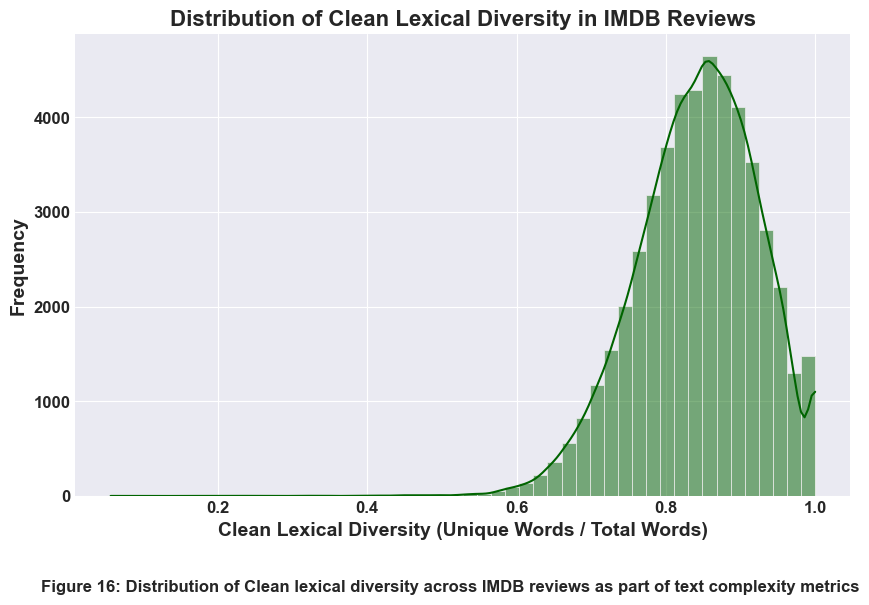

In [66]:
# Text Complexity Metrics:Lexical diversity (unique words / total words)
df_imdb['clean_lexical_diversity'] = df_imdb['cleaned_review'].apply(
    lambda x: len(set(str(x).split())) / len(str(x).split()) if len(str(x).split()) > 0 else 0
)

# Creating the figure
plt.figure(figsize=(10,6))

# Histogram of lexical diversity
sns.histplot(df_imdb['clean_lexical_diversity'], bins=50, kde=True, color="darkgreen")

# Adding bold title and axis labels
plt.title('Distribution of Clean Lexical Diversity in IMDB Reviews', fontsize=16, fontweight='bold')
plt.xlabel('Clean Lexical Diversity (Unique Words / Total Words)', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# Adding Bold tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding Caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 16: Distribution of Clean lexical diversity across IMDB reviews as part of text complexity metrics",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the figure
plt.savefig("lexical_diversity_distribution.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_29304\2675707015.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette="Set2")


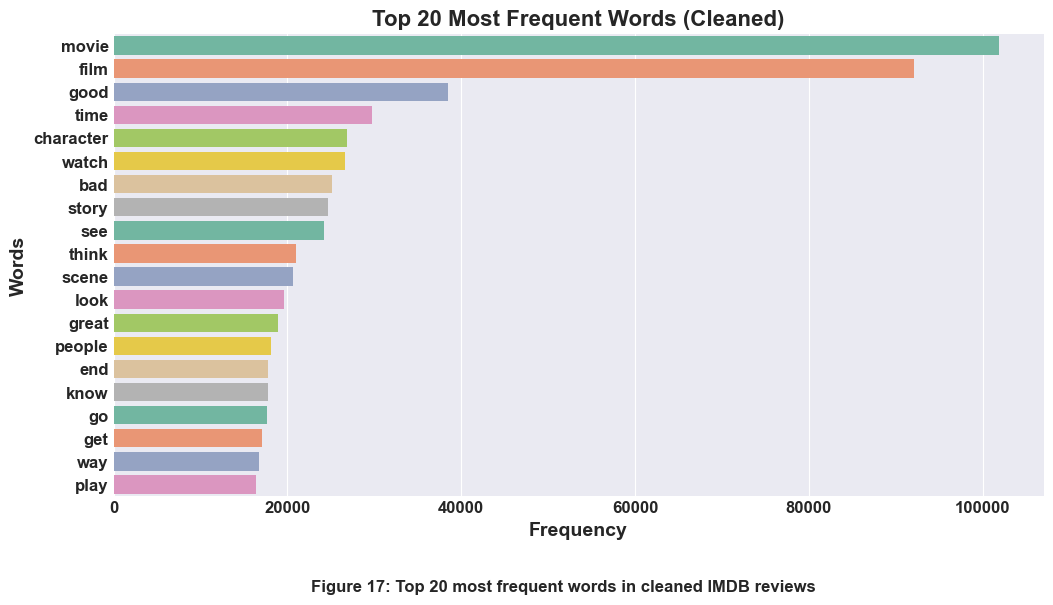

In [67]:
# Top words visualization using Bar chat in the clean review
from collections import Counter

all_words = ' '.join(df_imdb['cleaned_review']).split()
word_freq = Counter(all_words).most_common(20)

words = [x[0] for x in word_freq]
counts = [x[1] for x in word_freq]

# Applying consistent style
plt.style.use('seaborn-v0_8-darkgrid')  # Bold grid style

plt.figure(figsize=(12,6))  # Clear figure size

# Barplot with bold colors
sns.barplot(x=counts, y=words, palette="Set2")

# Adding bold title and labels
plt.title('Top 20 Most Frequent Words (Cleaned)', fontsize=16, fontweight='bold')
plt.xlabel('Frequency', fontsize=14, fontweight='bold')
plt.ylabel('Words', fontsize=14, fontweight='bold')

# Making tick labels larger and bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 17: Top 20 most frequent words in cleaned IMDB reviews",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the plot 
plt.savefig("clean_top20_words.png", dpi=300, bbox_inches='tight')

# Displaying the plot
plt.show()

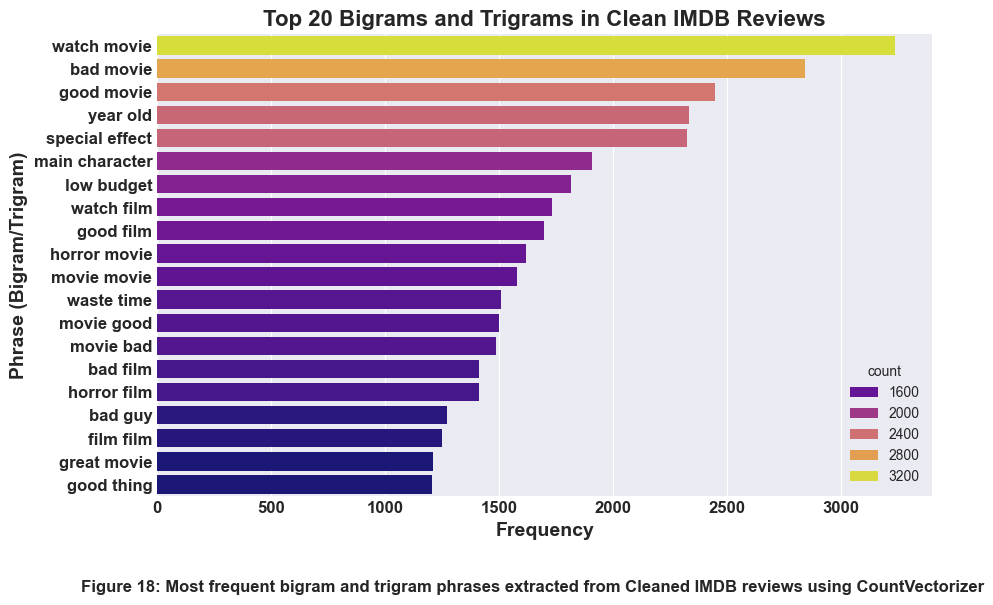

In [68]:
# Word Frequency and N-gram Analysis for the Clean Review (Top bigrams and trigrams)
vectorizer = CountVectorizer(ngram_range=(2,3), stop_words='english')
X = vectorizer.fit_transform(df_imdb['cleaned_review'])

# Summing up the counts of each token
word_counts = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

# Creating DataFrame of word frequencies
freq_df_imdb = pd.DataFrame({'phrase': words, 'count': word_counts})
freq_df_imdb = freq_df_imdb.sort_values(by='count', ascending=False).head(20)  # Top 20

# Creating the figure
plt.figure(figsize=(10,6))

# Barplot of top bigrams/trigrams
sns.barplot(x='count', y='phrase', data=freq_df_imdb, hue = 'count', palette="plasma")

# Adding bold title and axis labels
plt.title('Top 20 Bigrams and Trigrams in Clean IMDB Reviews', fontsize=16, fontweight='bold')
plt.xlabel('Frequency', fontsize=14, fontweight='bold')
plt.ylabel('Phrase (Bigram/Trigram)', fontsize=14, fontweight='bold')

# Adding Bold tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding Caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 18: Most frequent bigram and trigram phrases extracted from Cleaned IMDB reviews using CountVectorizer",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the figure
plt.savefig("clean_top_bigrams_trigrams.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

In [69]:
# Creating the input lists for the function calls
# Filtering the DataFrame and extracting the review text into two separate lists.
positive_hashtags = df_imdb[df_imdb['sentiment'] == 'positive']['cleaned_review'].tolist()
negative_hashtags = df_imdb[df_imdb['sentiment'] == 'negative']['cleaned_review'].tolist()

# Generating a WordCloud function for the Clean IMDB dataset 
def getWordCloud(hashtags, title_text, filename, caption_text, figure_number):
    """ 
    Generates, displays, and saves a WordCloud.
    
    Args:
        hashtags (list): The cleaned text (words) to generate the cloud from.
        title_text (str): The title to use for the plot.
        filename (str): The filename for saving the figure.
        caption_text (str): The caption to display below the plot.
        figure_number (int): The figure number for the caption.
    """

    # Reading the whole text
    text = ' '.join(hashtags)

    # Applying consistent style
    plt.style.use('seaborn-v0_8-darkgrid')  # Bold grid style

    # Generating a word cloud image
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap='Set2', max_font_size=120, 
                          random_state=42).generate(text)

    # Setting a clear figure size
    plt.figure(figsize=(10,6))

    # Displaying the generated image
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

    # Adding bold title (using the dynamic input title)
    plt.title(title_text, fontsize=16, fontweight='bold')

    # Adding caption below the plot (using the dynamic input caption)
    plt.figtext(0.5, -0.05,
                f"Figure {figure_number}: {caption_text}",
                wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

    # Saving figure with high resolution for reports (using the dynamic filename)
    plt.savefig(filename, dpi=300, bbox_inches='tight')

    # Displaying the plot
    plt.show()

Generating WordCloud for Positive Reviews...


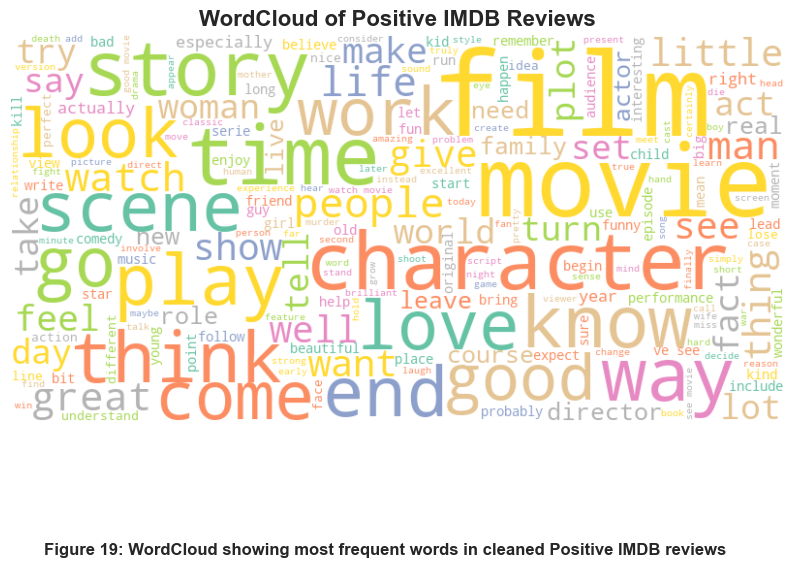

Generating WordCloud for Negative Reviews...


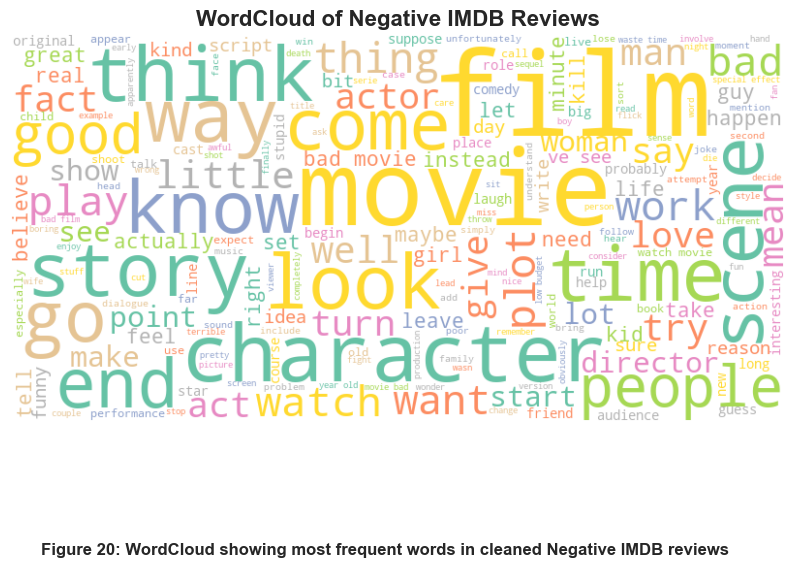

In [70]:
# Applying the function twice for both reviews
# Positive Reviews
print("Generating WordCloud for Positive Reviews...")
getWordCloud(
    hashtags=positive_hashtags, 
    title_text='WordCloud of Positive IMDB Reviews', 
    filename='clean_positive_wordcloud_imdb.png',
    caption_text='WordCloud showing most frequent words in cleaned Positive IMDB reviews',
    figure_number=19 
)

# Negative Reviews
print("Generating WordCloud for Negative Reviews...")
getWordCloud(
    hashtags=negative_hashtags, 
    title_text='WordCloud of Negative IMDB Reviews', 
    filename='clean_negative_wordcloud_imdb.png',
    caption_text='WordCloud showing most frequent words in cleaned Negative IMDB reviews',
    figure_number=20 
)

5. DATA PREPARATION,TRAIN/TEST SPLIT AND VECTORIZATION.

In [71]:
# Importing the neccessary libraries
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

In [72]:
# Converting text into word counts with CountVectorizer and then applying TF‑IDF weighting using TfidfTransformer
pipeline = Pipeline([ 
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
])

In [73]:
# Preparing X as the text data and y as binary sentiment labels (1 = positive, 0 = negative) for machine learning.
X = strings
y = (df_imdb["sentiment"] == "positive").astype(int).to_numpy()

In [74]:
# Splitting the features and labels into training (70%) and testing (30%) sets for model evaluation.
xtrain_str, xtest_str, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)

In [75]:
# fitting the pipeline on the training text (xtrain_str) and transforming it into numerical feature vectors (xtrain) for model training.
xtrain = pipeline.fit_transform(xtrain_str)

In [76]:
# Using the already‑fitted pipeline to transform the test text data (xtest_str) into numerical feature vectors (xtest) for evaluation.
xtest = pipeline.transform(xtest_str)

In [77]:
# Checking if the training datasets are balanced
print(f"{sum(ytrain == 1)} positive reviews")
print(f"{sum(ytrain == 0)} negative reviews")

17413 positive reviews
17294 negative reviews


In [78]:
# The training dataset above are almost the same.

6a. TRADITIONAL MACHINE LEARNING MODEL 1-MULTINOMIAL NAIVE BAYES MODEL

In [79]:
# Importing the library
from sklearn.naive_bayes import MultinomialNB 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, precision_score, classification_report

6ai. IMPLEMENTATION OF MULTINOMIAL NAIVE BAYES MODEL (WITHOUT HYPERPARAMETER TUNING)

In [80]:
# Creating a Naive Bayes classifier that models text data using word frequency counts for classification.
No_HP_NBmodel = MultinomialNB()

In [81]:
# Fitting the model on the training data.
print("\nTraining Naive Bayes..")
No_HP_NBmodel.fit(xtrain, ytrain)


Training Naive Bayes..


MultinomialNB()

In [82]:
# Generating the predicted sentiment labels for the unseen test data (xtest)
ypred_No_HP_NB = No_HP_NBmodel.predict(xtest)
ypred_No_HP_NB_probs = No_HP_NBmodel.predict_proba(xtest)[:, 1]   # probability scores for ROC-AUC and Log Loss

In [83]:
# Accuracy
No_HP_NB_test_acc = No_HP_NBmodel.score(xtest, ytest)
print("Test Accuracy with Best Parameters for Naive Bayes without hyperpameter tuning: {:.4f}".format(No_HP_NB_test_acc))

Test Accuracy with Best Parameters for Naive Bayes without hyperpameter tuning: 0.8563


In [84]:
# Computing ROC-AUC which evaluates how well the model separates classes across thresholds
ypred_No_HP_nb_roc_auc = roc_auc_score(ytest, ypred_No_HP_NB_probs)
print("ROC-AUC for Naive Bayes Without Hyperparameter Tuning: {:.4f}".format(ypred_No_HP_nb_roc_auc))

ROC-AUC for Naive Bayes Without Hyperparameter Tuning: 0.9318


In [85]:
# Computing Log Loss(Cross-entropy) which penalizes confident wrong predictions (lower is better)
No_HP_NBlogloss = log_loss(ytest, ypred_No_HP_NB_probs)
print("Log Loss for Naive Bayes Without Hyperparameter Tuning: {:.4f}".format(No_HP_NBlogloss))

Log Loss for Naive Bayes Without Hyperparameter Tuning: 0.4098


In [86]:
# Computing Precision,which measures how many predicted positives are truly positive. 
No_HP_nbprecision = precision_score(ytest, ypred_No_HP_NB)
print("Precision  for Naive Bayes: {:.4f}".format(No_HP_nbprecision))

Precision  for Naive Bayes: 0.8551


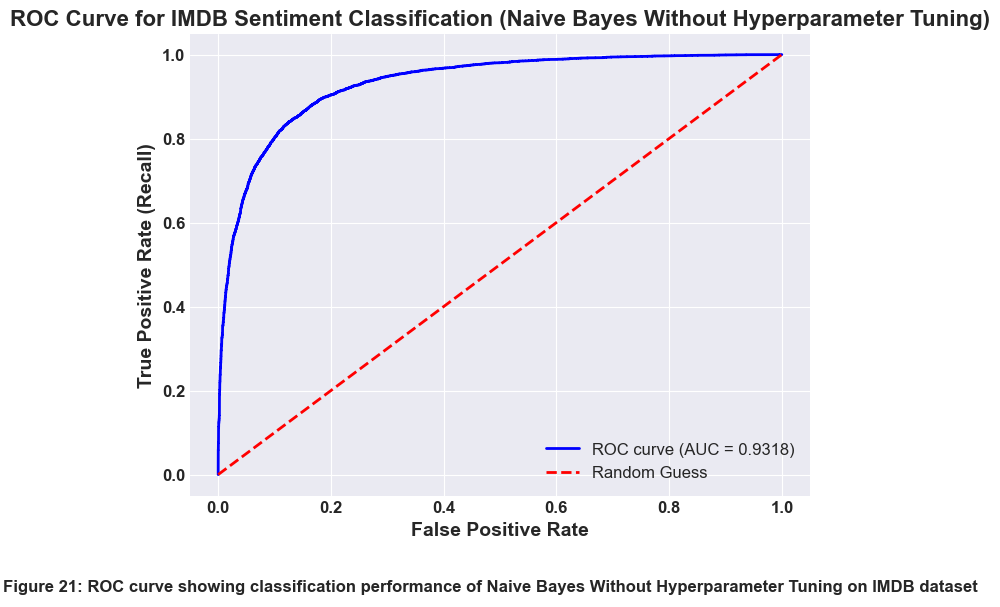

In [87]:
# Computing ROC curve values
fpr, tpr, thresholds = roc_curve(ytest, ypred_No_HP_NB_probs) # fpr is false positive rate, tpr is true positive rate

plt.figure(figsize=(8,6))

# Plotting ROC curve to compute False Positive Rate (FPR) and True Positive Rate (TPR) at different thresholds
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {ypred_No_HP_nb_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')

# Adding bold title and labels
plt.title('ROC Curve for IMDB Sentiment Classification (Naive Bayes Without Hyperparameter Tuning)', fontsize=16, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate (Recall)', fontsize=14, fontweight='bold')

# Customizing ticks
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding legend
plt.legend(loc='lower right', fontsize=12)

# Caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 21: ROC curve showing classification performance of Naive Bayes Without Hyperparameter Tuning on IMDB dataset",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the plot
plt.savefig("no_hp_roc_curve_nb_imdb.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

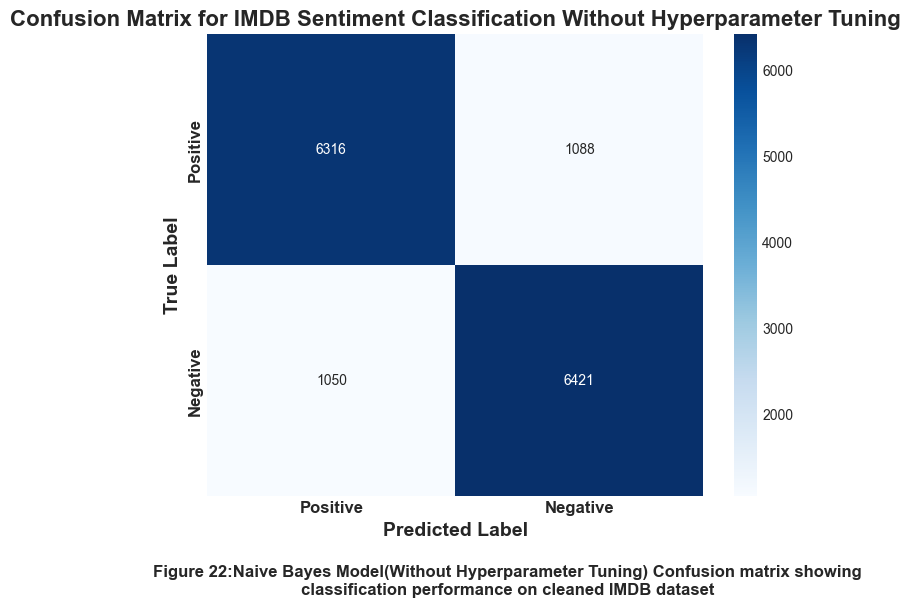

In [88]:
# Generating confusion matrix
cm_no_hp_nb = confusion_matrix(ytest, ypred_No_HP_NB, labels=[0, 1])   # ytest is the true labels and ypred_No_HP_NB is the predicted labels.

plt.figure(figsize=(8,6))  # figure size

# Heatmap with bold colors
sns.heatmap(cm_no_hp_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Positive', 'Negative'],
            yticklabels=['Positive', 'Negative'])

# Adding bold title and labels
plt.title('Confusion Matrix for IMDB Sentiment Classification Without Hyperparameter Tuning', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')

# Making tick labels larger and bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 22:Naive Bayes Model(Without Hyperparameter Tuning) Confusion matrix showing classification performance on cleaned IMDB dataset",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving plot with high resolution for reports
plt.savefig("confusion_matrix_imdb_no_hp_naive_bayes.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [89]:
# printing Classification report for precision, recall, f1-score for Naive Bayes Model Without Hyperparameter Tuning
print(classification_report(ytest, ypred_No_HP_NB, target_names=['positive', 'negative'],digits=4))

              precision    recall  f1-score   support

    positive     0.8575    0.8531    0.8552      7404
    negative     0.8551    0.8595    0.8573      7471

    accuracy                         0.8563     14875
   macro avg     0.8563    0.8563    0.8563     14875
weighted avg     0.8563    0.8563    0.8563     14875



6aii. IMPLEMENTATION OF MULTINOMIAL NAIVE BAYES MODEL (WITH HYPERPARAMETER TUNING)

In [90]:
# Creating a Naive Bayes classifier that models text data.
NBmodel = MultinomialNB()

# Defining hyperparameters to tune
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]   # Laplace smoothing values
}

# Running Grid Search
grid_nb = GridSearchCV(
    estimator=NBmodel,
    param_grid=param_grid,
    cv=3,            # 3-fold cross-validation
    n_jobs=-1,       # using all cores
    verbose=1
)

In [91]:
# Running cross‑validated training of the model across the specified hyperparameter grid,
# selecting the best parameters, and refitting the optimized model on the training data.
print("\nTraining Naive Bayes with GridSearchCV...")
grid_nb.fit(xtrain, ytrain)


Training Naive Bayes with GridSearchCV...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}, verbose=1)

In [92]:
# Printing best parameters and best score
print("\nBest Parameters for Naive Bayes:", grid_nb.best_params_)
print("Best Cross-Validation Accuracy for Naive Bayes: {:.4f}".format(grid_nb.best_score_))


Best Parameters for Naive Bayes: {'alpha': 5.0}
Best Cross-Validation Accuracy for Naive Bayes: 0.8583


In [93]:
# Generating the predicted sentiment labels for the unseen test data (xtest)
ypred_NB = grid_nb.predict(xtest)
ypred_NB_probs = grid_nb.predict_proba(xtest)[:, 1]   # probability scores for ROC-AUC and Log Loss

In [94]:
# Accuracy
NB_test_acc = grid_nb.score(xtest, ytest)
print("Test Accuracy with Best Parameters for Naive Bayes with hyperpameter tuning: {:.4f}".format(NB_test_acc))

Test Accuracy with Best Parameters for Naive Bayes with hyperpameter tuning: 0.8589


In [95]:
# Computing Receiver Operating Characteristic – Area Under the Curve.ROC-AUC which evaluates how well the model separates classes across thresholds
nb_roc_auc = roc_auc_score(ytest, ypred_NB_probs)
print("ROC-AUC for Naive Bayes With Hyperparameter Tuning: {:.4f}".format(nb_roc_auc))

ROC-AUC for Naive Bayes With Hyperparameter Tuning: 0.9318


In [96]:
# Computing Log Loss(Cross-entropy) which penalizes confident wrong predictions (lower is better)
NBlogloss = log_loss(ytest, ypred_NB_probs)
print("Log Loss for Naive Bayes With Hyperparameter Tuning: {:.4f}".format(NBlogloss))

Log Loss for Naive Bayes With Hyperparameter Tuning: 0.4531


In [97]:
# Computing Precision,which measures how many predicted positives are truly positive. 
nbprecision = precision_score(ytest, ypred_NB)
print("Precision  for Naive Bayes With Hyperparameter Tuning: {:.4f}".format(nbprecision))

Precision  for Naive Bayes With Hyperparameter Tuning: 0.8642


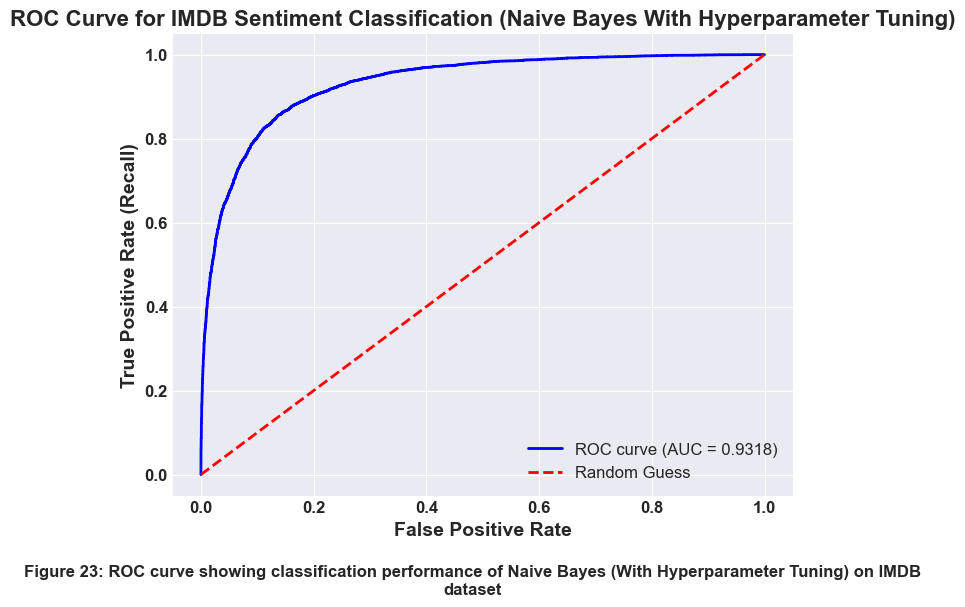

In [98]:
# Computing ROC curve values
fpr, tpr, thresholds = roc_curve(ytest, ypred_NB_probs) # fpr is false positive rate, tpr is true positive rate

plt.figure(figsize=(8,6))

# Plotting ROC curve to computes False Positive Rate (FPR) and True Positive Rate (TPR) at different thresholds
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {nb_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')

# Adding bold title and labels
plt.title('ROC Curve for IMDB Sentiment Classification (Naive Bayes With Hyperparameter Tuning)', fontsize=16, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate (Recall)', fontsize=14, fontweight='bold')

# Customizing ticks
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding legend
plt.legend(loc='lower right', fontsize=12)

# Caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 23: ROC curve showing classification performance of Naive Bayes (With Hyperparameter Tuning) on IMDB dataset",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the plot
plt.savefig("roc_curve_nb_imdb.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

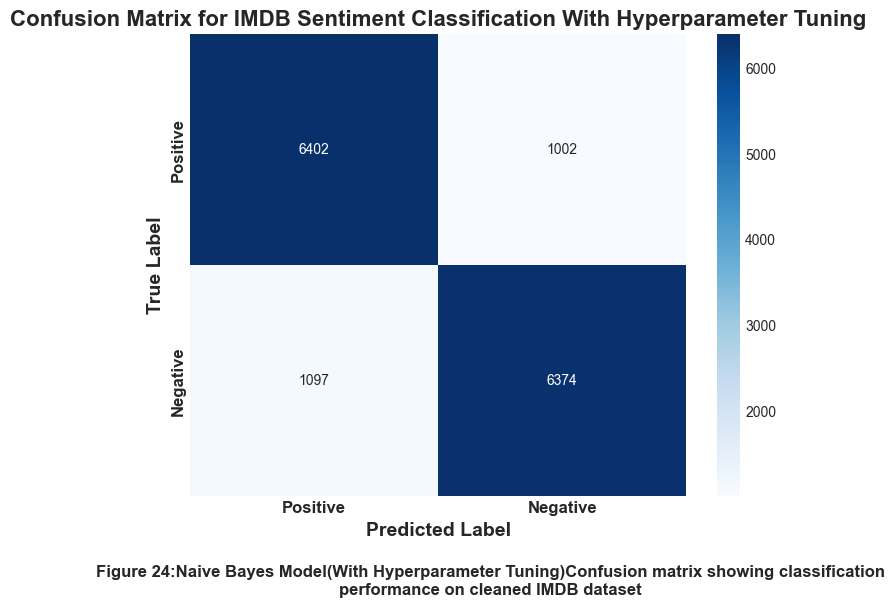

In [99]:
# Generating confusion matrix
cm_nb = confusion_matrix(ytest, ypred_NB, labels=[0, 1])   # ytest is the true labels and ypred_NB is the predicted labels.

plt.figure(figsize=(8,6))  # figure size

# Heatmap with bold colors
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Positive', 'Negative'],
            yticklabels=['Positive', 'Negative'])

# Adding bold title and labels
plt.title('Confusion Matrix for IMDB Sentiment Classification With Hyperparameter Tuning', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')

# Making tick labels larger and bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 24:Naive Bayes Model(With Hyperparameter Tuning)Confusion matrix showing classification performance on cleaned IMDB dataset",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving plot with high resolution for reports
plt.savefig("confusion_matrix_imdb_naive_bayes.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [100]:
# printing Classification report for precision, recall, f1-score for Naive Bayes Model With Hyperparameter Tuning
print(classification_report(ytest, ypred_NB, target_names=['positive', 'negative'],digits=4))

              precision    recall  f1-score   support

    positive     0.8537    0.8647    0.8592      7404
    negative     0.8642    0.8532    0.8586      7471

    accuracy                         0.8589     14875
   macro avg     0.8589    0.8589    0.8589     14875
weighted avg     0.8590    0.8589    0.8589     14875



6b. TRADITIONAL MACHINE LEARNING MODEL 2-SUPPORT VECTOR MACHINE

In [101]:
# Importing the library required
from sklearn.svm import LinearSVC # LinearSVC is preferred for large text classification tasks
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

6bi. IMPLEMENTATION OF SUPPORT VECTOR MACHINE (WITHOUT HYPERPARAMETER TUNING) 

In [102]:
# Defining the support vector machine model without hyperparameter
base_svc = LinearSVC(random_state=42, dual=True) # Setting dual=True because for text data, features (words) usually outnumber samples

# Adding calibration to enable probability outputs (predict_proba)
no_hp_calibrated_svc = CalibratedClassifierCV(estimator=base_svc, cv=3)

# Creating the Pipeline with standard defaults
no_hp_model_svm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', no_hp_calibrated_svc)
])

In [103]:
# Split data: 70% training, 30% testing
xtrain, xtest, ytrain, ytest = train_test_split(
    strings,  #  cleaned text data
    (df_imdb["sentiment"] == "positive").astype(int).to_numpy(),  # binary labels
    test_size=0.3,
    random_state=42,
    stratify=(df_imdb["sentiment"] == "positive").astype(int)  # preserves class balance
)

In [104]:
# Fitting the model on the training data.
print("Training default SVM model...")
no_hp_model_svm.fit(xtrain, ytrain)

Training default SVM model...


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('svc',
                 CalibratedClassifierCV(cv=3,
                                        estimator=LinearSVC(dual=True,
                                                            random_state=42)))])

In [105]:
# Generating the predicted sentiment labels for the unseen test data (xtest)
ypred_no_hp_svm = no_hp_model_svm.predict(xtest)
ypred_no_hp_svm_probs = no_hp_model_svm.predict_proba(xtest)[:, 1]  # probability scores for ROC-AUC & Log Loss

In [106]:
# Accuracy
no_hp_svm_test_acc = no_hp_model_svm.score(xtest, ytest)
print("Test Accuracy with Best Parameters for Support Vector Machine without Hyperparameter Tuning: {:.4f}".format(no_hp_svm_test_acc))

Test Accuracy with Best Parameters for Support Vector Machine without Hyperparameter Tuning: 0.8861


In [107]:
# Getting the probability scores for the positive class .
# This is the standard method for obtaining ROC-AUC scores from calibrated models.
# Calculating ROC-AUC using the probability scores
no_hp_svm_roc_auc = roc_auc_score(ytest, ypred_no_hp_svm_probs)

print("ROC-AUC for Support Vector Machine Without Hyperparameter Tuning: {:.4f}".format(no_hp_svm_roc_auc))

ROC-AUC for Support Vector Machine Without Hyperparameter Tuning: 0.9518


In [108]:
# Precision
no_hp_svmprecision = precision_score(ytest, ypred_no_hp_svm)
print("Precision for Support Vector Machine Without Hyperparameter Tuning: {:.4f}".format(no_hp_svmprecision))

Precision for Support Vector Machine Without Hyperparameter Tuning: 0.8793


In [109]:
# Computing Log Loss (Cross-entropy) which penalizes confident wrong predictions (lower is better)
no_hp_svmlogloss = log_loss(ytest, ypred_no_hp_svm_probs)
print("Log Loss for Support Vector Machine Without Hyperparameter Tuning : {:.4f}".format(no_hp_svmlogloss))

Log Loss for Support Vector Machine Without Hyperparameter Tuning : 0.2829


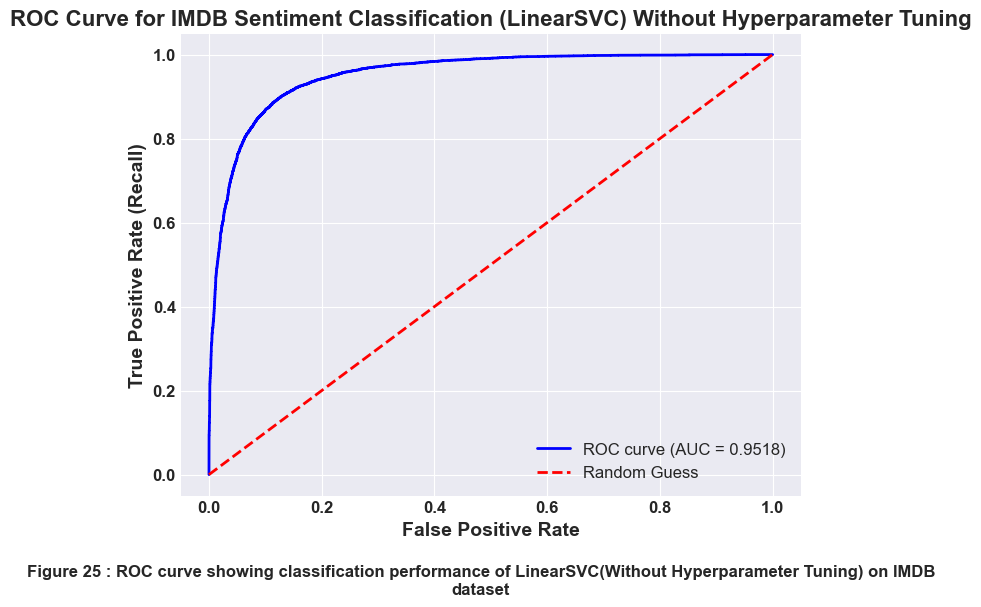

In [110]:
# Computing ROC curve values
fpr, tpr, thresholds = roc_curve(ytest, ypred_no_hp_svm_probs)

plt.figure(figsize=(8,6))

# Plotting ROC curve to compute False Positive Rate (FPR) and True Positive Rate (TPR) at different thresholds
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {no_hp_svm_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')

# Adding bold title and labels
plt.title('ROC Curve for IMDB Sentiment Classification (LinearSVC) Without Hyperparameter Tuning', fontsize=16, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate (Recall)', fontsize=14, fontweight='bold')

# Customizing ticks
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding legend
plt.legend(loc='lower right', fontsize=12)

# Caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 25 : ROC curve showing classification performance of LinearSVC(Without Hyperparameter Tuning) on IMDB dataset",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the plot
plt.savefig("no_hp_roc_curve_svm_imdb.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

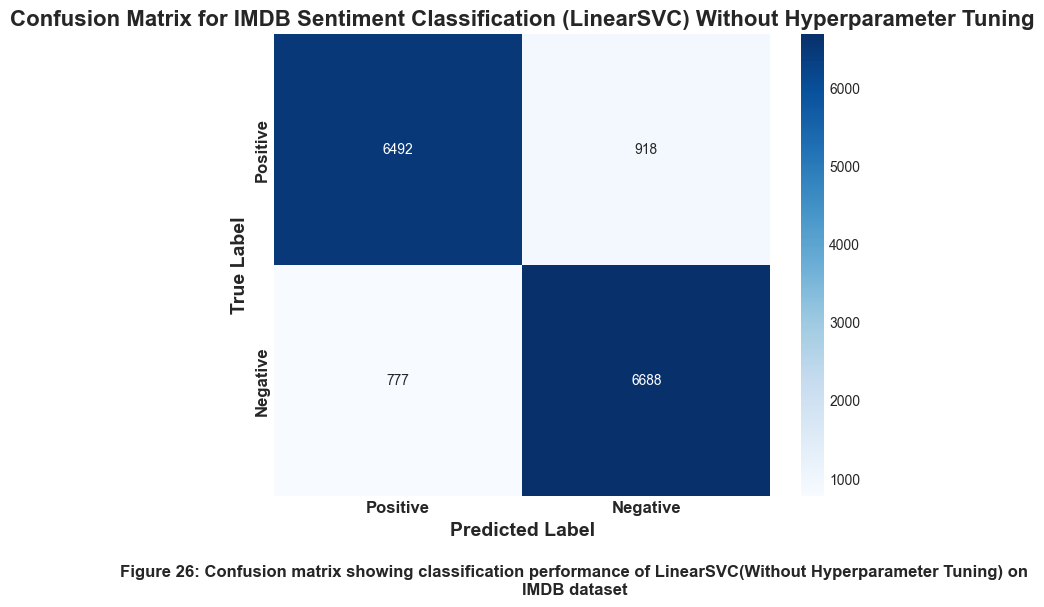

In [111]:
# Generating confusion matrix
no_hp_svm_cm = confusion_matrix(ytest, ypred_no_hp_svm, labels=[0, 1])   # ytest = true labels, ypred_no_hp_svm = predicted labels

plt.figure(figsize=(8,6))  # figure size

# Heatmap with bold colors
sns.heatmap(no_hp_svm_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Positive', 'Negative'],
            yticklabels=['Positive', 'Negative'])

# Adding bold title and labels
plt.title('Confusion Matrix for IMDB Sentiment Classification (LinearSVC) Without Hyperparameter Tuning', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')

# Making tick labels larger and bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 26: Confusion matrix showing classification performance of LinearSVC(Without Hyperparameter Tuning) on IMDB dataset",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving plot with high resolution for reports
plt.savefig("confusion_matrix_no_hp_svm_imdb.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [112]:
# Full classification report (precision, recall, F1-score, support)
print("\nClassification Report for Support Vector Machine Without Hyperparameter Tuning:\n")
print(classification_report(ytest, ypred_no_hp_svm, target_names=['Positive','Negative'], digits =4))


Classification Report for Support Vector Machine Without Hyperparameter Tuning:

              precision    recall  f1-score   support

    Positive     0.8931    0.8761    0.8845      7410
    Negative     0.8793    0.8959    0.8875      7465

    accuracy                         0.8861     14875
   macro avg     0.8862    0.8860    0.8860     14875
weighted avg     0.8862    0.8861    0.8860     14875



6bii. IMPLEMENTATION OF SUPPORT VECTOR MACHINE (WITH HYPERPARAMETER TUNING) 

In [113]:
# Defining the base estimator and wrapping it for probability output
base_svc = LinearSVC(random_state=42, dual=True) 

calibrated_svc = CalibratedClassifierCV(
    estimator=base_svc, 
    method='sigmoid', 
    cv=3      # 3 folds for faster calibration
)

# Defining the Pipeline
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', calibrated_svc)
])

# Defining the parameter grid 
param_grid = {
    
    'tfidf__max_features': [5000, 10000, None],
    
    # Using unigram and bigram
    'tfidf__ngram_range': [(1, 1), (1, 2)], 
      
    'tfidf__binary': [True], 
    
    'svc__estimator__C': [0.1, 1.0, 10.0], 
    
    'svc__estimator__loss': ['squared_hinge'], 
    
    # penalty type 
    'svc__estimator__penalty': ['l2'], 
    
    'svc__estimator__dual': [True], 
    
    # Calibration Method 
    'svc__method': ['sigmoid'] 
}


grid_svm = GridSearchCV(
    estimator=pipeline_svm, 
    param_grid=param_grid, 
    cv=3, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=1
)

In [114]:
# Running cross‑validated training of the model across the specified hyperparameter grid,
# selecting the best parameters, and refitting the optimized model on the training data.
print("\nTraining LinearSVC with GridSearchCV...")
grid_svm.fit(xtrain, ytrain)


Training LinearSVC with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svc',
                                        CalibratedClassifierCV(cv=3,
                                                               estimator=LinearSVC(dual=True,
                                                                                   random_state=42)))]),
             n_jobs=-1,
             param_grid={'svc__estimator__C': [0.1, 1.0, 10.0],
                         'svc__estimator__dual': [True],
                         'svc__estimator__loss': ['squared_hinge'],
                         'svc__estimator__penalty': ['l2'],
                         'svc__method': ['sigmoid'], 'tfidf__binary': [True],
                         'tfidf__max_features': [5000, 10000, None],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='roc_auc', verbose=1)

In [115]:
# Printing best parameters and best score
print("\nBest Parameters for Support Vector Machine With Hyperparameter Tuning:", grid_svm.best_params_)
print("Best Cross-Validation Accuracy for Support Vector Machine With Hyperparameter Tuning: {:.4f}".format(grid_svm.best_score_))


Best Parameters for Support Vector Machine With Hyperparameter Tuning: {'svc__estimator__C': 10.0, 'svc__estimator__dual': True, 'svc__estimator__loss': 'squared_hinge', 'svc__estimator__penalty': 'l2', 'svc__method': 'sigmoid', 'tfidf__binary': True, 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 2)}
Best Cross-Validation Accuracy for Support Vector Machine With Hyperparameter Tuning: 0.9527


In [116]:
# Generating the predicted sentiment labels for the unseen test data (xtest)
ypred_svm = grid_svm.predict(xtest)
ypred_svm_probs = grid_svm.predict_proba(xtest)[:, 1]  # probability scores for ROC-AUC & Log Loss

In [117]:
# Accuracy
svm_test_acc = grid_svm.score(xtest, ytest)
print("Test Accuracy with Best Parameters for Support Vector Machine With Hyperparameter Tuning: {:.4f}".format(svm_test_acc))

Test Accuracy with Best Parameters for Support Vector Machine With Hyperparameter Tuning: 0.9572


In [118]:
# Getting the probability scores for the positive class .
# This is the standard method for obtaining ROC-AUC scores from calibrated models.
# This requires the pipeline to use CalibratedClassifierCV(LinearSVC)
# Calculating ROC-AUC using the probability scores
svm_roc_auc = roc_auc_score(ytest, ypred_svm_probs)

print("ROC-AUC for Support Vector Machine With Hyperparameter Tuning: {:.4f}".format(svm_roc_auc))

ROC-AUC for Support Vector Machine With Hyperparameter Tuning: 0.9572


In [119]:
# Precision
svmprecision = precision_score(ytest, ypred_svm)
print("Precision for Support Vector Machine With Hyperparameter Tuning: {:.4f}".format(svmprecision))

Precision for Support Vector Machine With Hyperparameter Tuning: 0.8856


In [120]:
# Computing Log Loss (Cross-entropy) which penalizes confident wrong predictions (lower is better)
svmlogloss = log_loss(ytest, ypred_svm_probs)
print("Log Loss for Support Vector Machine With Hyperparameter Tuning: {:.4f}".format(svmlogloss))

Log Loss for Support Vector Machine With Hyperparameter Tuning: 0.2683


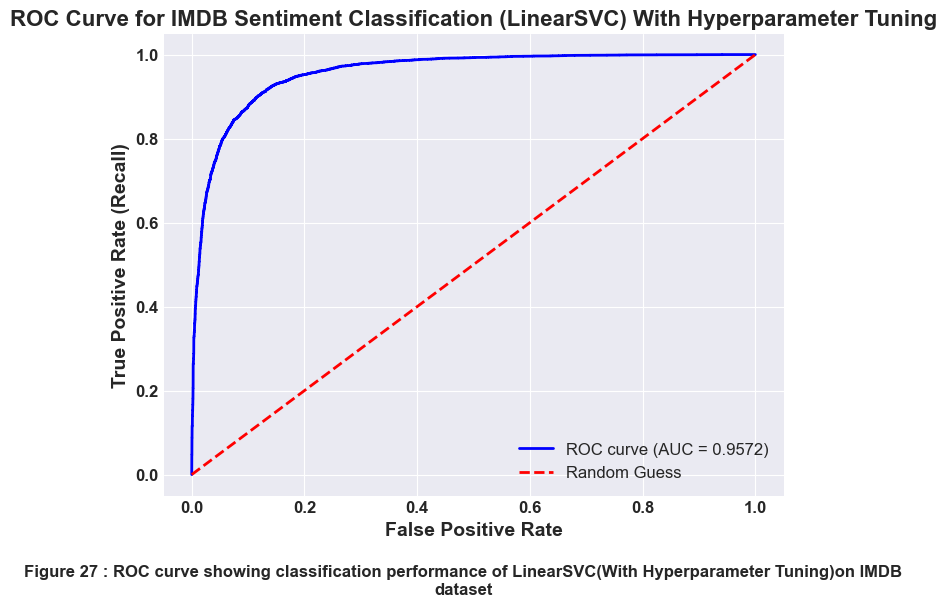

In [121]:
# Computing ROC curve values
fpr, tpr, thresholds = roc_curve(ytest, ypred_svm_probs)

plt.figure(figsize=(8,6))

# Plotting ROC curve to compute False Positive Rate (FPR) and True Positive Rate (TPR) at different thresholds
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {svm_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')

# Adding bold title and labels
plt.title('ROC Curve for IMDB Sentiment Classification (LinearSVC) With Hyperparameter Tuning', fontsize=16, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate (Recall)', fontsize=14, fontweight='bold')

# Customizing ticks
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding legend
plt.legend(loc='lower right', fontsize=12)

# Caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 27 : ROC curve showing classification performance of LinearSVC(With Hyperparameter Tuning)on IMDB dataset",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving the plot
plt.savefig("roc_curve_svm_imdb.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

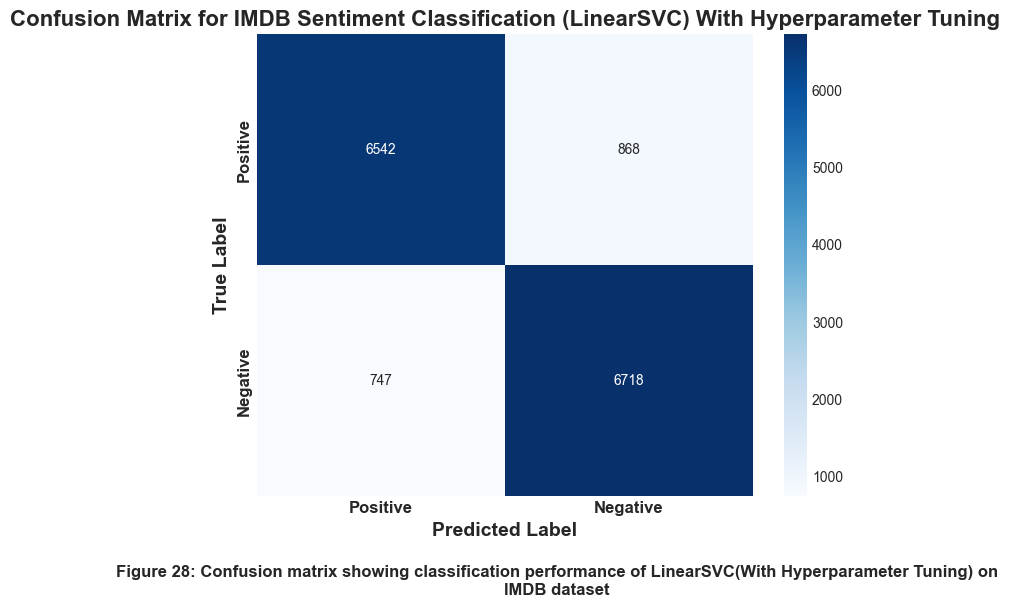

In [122]:
# Generating confusion matrix
svm_cm = confusion_matrix(ytest, ypred_svm, labels=[0, 1])   # ytest = true labels, ypred_svm = predicted labels

plt.figure(figsize=(8,6))  # figure size

# Heatmap with bold colors
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Positive', 'Negative'],
            yticklabels=['Positive', 'Negative'])

# Adding bold title and labels
plt.title('Confusion Matrix for IMDB Sentiment Classification (LinearSVC) With Hyperparameter Tuning', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')

# Making tick labels larger and bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 28: Confusion matrix showing classification performance of LinearSVC(With Hyperparameter Tuning) on IMDB dataset",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving plot with high resolution for reports
plt.savefig("confusion_matrix_svm_imdb.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

In [123]:
# Full classification report (precision, recall, F1-score, support)
print("\nClassification Report for Support Vector Machine With Hyperparameter Tuning:\n")
print(classification_report(ytest, ypred_svm, target_names=['Positive','Negative'], digits =4))


Classification Report for Support Vector Machine With Hyperparameter Tuning:

              precision    recall  f1-score   support

    Positive     0.8975    0.8829    0.8901      7410
    Negative     0.8856    0.8999    0.8927      7465

    accuracy                         0.8914     14875
   macro avg     0.8915    0.8914    0.8914     14875
weighted avg     0.8915    0.8914    0.8914     14875



7. DEEP LEARNING DEEP LEARNING MODELS

In [124]:
# Installing and importing the required libraries
# Importing the required libraries
!pip install --upgrade keras tensorflow

In [125]:
!pip install --upgrade scikit-learn scikeras

In [126]:
!pip install keras-tuner --upgrade

In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier 
from sklearn.base import BaseEstimator, ClassifierMixin
import keras_tuner as kt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
import collections

C:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resour

In [128]:
# To determine MAX_WORD
# Fit a vectorizer on the clean text
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(strings)

# Summing unique words in the dataset
vocab_size = len(vectorizer.vocabulary_)
print("Full vocabulary size:", vocab_size)

Full vocabulary size: 63656


In [129]:
# Flattening all words into a list
all_words = " ".join(strings).split()
word_freq = collections.Counter(all_words)
# Showing the 20 most common words
print(word_freq.most_common(20))

[('movie', 101914), ('film', 92070), ('good', 38535), ('time', 29780), ('character', 26919), ('watch', 26594), ('bad', 25097), ('story', 24712), ('see', 24189), ('think', 20971), ('scene', 20704), ('look', 19595), ('great', 18940), ('people', 18101), ('end', 17825), ('know', 17719), ('go', 17638), ('get', 17108), ('way', 16746), ('play', 16406)]


In [130]:
# To determine MAX_LEN
review_lengths = [len(review.split()) for review in strings]
print("Average length:", np.mean(review_lengths))
print("Median length:", np.median(review_lengths))
print("90th percentile length:", np.percentile(review_lengths, 90))
print("Max length:", np.max(review_lengths))

Average length: 87.37144528256222
Median length: 65.0
90th percentile length: 172.0
Max length: 990


In [131]:
# MAX_WORDS is set to capture the most informative terms while ignoring rare ones.
# MAX_LEN is to set it at the 90th percentile so most reviews are preserved while avoiding extreme outliers.
MAX_WORDS = 20000
MAX_LEN = 172

# Tokenizing
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(strings)

In [132]:
X = pad_sequences(tokenizer.texts_to_sequences(strings),maxlen = MAX_LEN)  #padding the strings data
y = (df_imdb["sentiment"] == "positive").astype(int).to_numpy()

In [133]:
# Splilting the features and labels into training (70%) and testing (30%) sets for model evaluation.
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)

7ai. IMPLEMENTATION OF BIDIRECTIONAL LONG SHORT-TERM MEMORY MODEL(A TYPE OF RECURRENT NEURAL NETWORK ARCHITECTURE) WITHOUT HYPERPARAMETER TUNING

In [134]:
# Standard architecture for binary text classification
no_hp_bilstmmodel = Sequential([
    # Turning word indices into 128-dimensional vectors
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    
    # Standard BiLSTM (64 units is the most common default)
    Bidirectional(LSTM(64)),
    
    # Regularization to prevent overfitting
    Dropout(0.5),
    
    # for Binary output (0 or 1)
    Dense(1, activation='sigmoid')
])

no_hp_bilstmmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

C:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [135]:
# Defining the callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the Bilstm model
print("Starting BiLSTM training...")
history = no_hp_bilstmmodel.fit(
    xtrain, ytrain,
    epochs=5,
    batch_size=32,
    validation_split=0.2, # Using 20% of xtrain and ytrain data
    callbacks=[early_stop]
)

Starting BiLSTM training...
Epoch 1/5
868/868 ━━━━━━━━━━━━━━━━━━━━ 124s 138ms/step - accuracy: 0.8212 - loss: 0.3948 - val_accuracy: 0.8630 - val_loss: 0.3348
Epoch 2/5
868/868 ━━━━━━━━━━━━━━━━━━━━ 119s 137ms/step - accuracy: 0.9137 - loss: 0.2273 - val_accuracy: 0.8652 - val_loss: 0.3135
Epoch 3/5
868/868 ━━━━━━━━━━━━━━━━━━━━ 117s 135ms/step - accuracy: 0.9444 - loss: 0.1533 - val_accuracy: 0.8593 - val_loss: 0.3858
Epoch 4/5
868/868 ━━━━━━━━━━━━━━━━━━━━ 117s 135ms/step - accuracy: 0.9645 - loss: 0.1021 - val_accuracy: 0.8580 - val_loss: 0.4412
Epoch 5/5
868/868 ━━━━━━━━━━━━━━━━━━━━ 129s 149ms/step - accuracy: 0.9735 - loss: 0.0805 - val_accuracy: 0.8584 - val_loss: 0.5873


In [136]:
no_hp_bilstmmodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 172, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,976,837 (30.43 MB)

 Trainable params: 2,658,945 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,317,892 (20.29 MB)

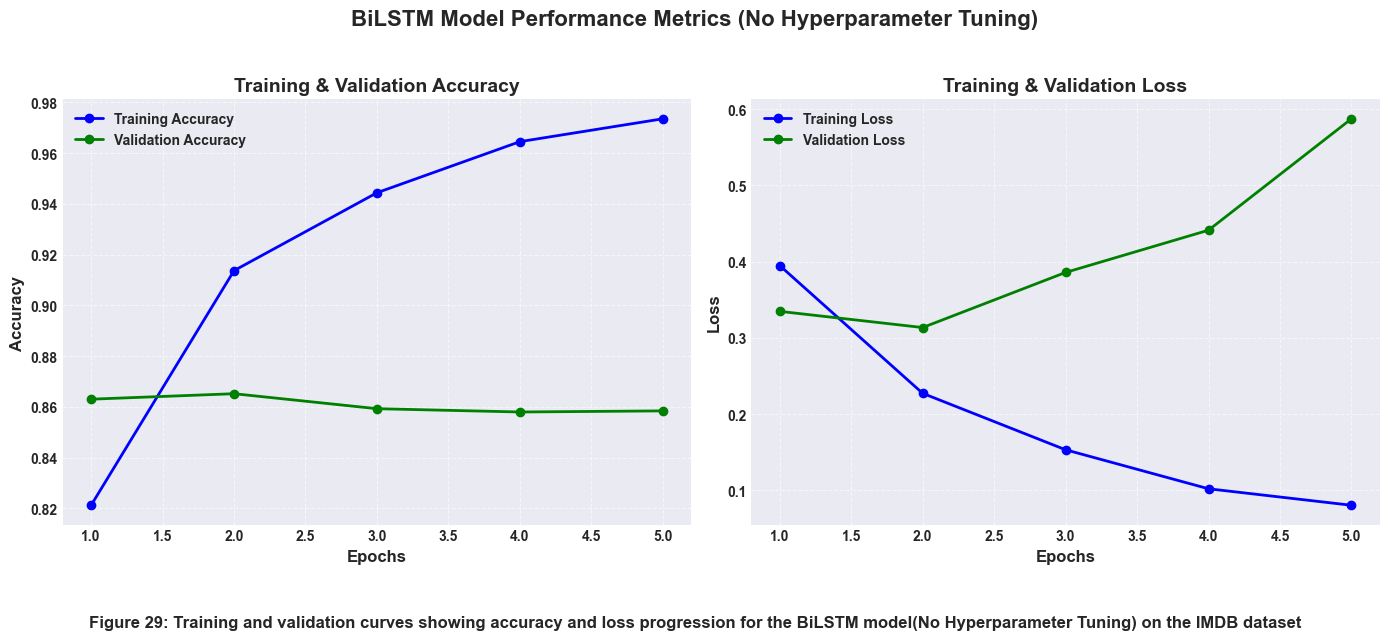

In [137]:
# Plotting the Training versus Validation Accuracy and Loss.This is the standard way to detect overfitting in Deep Learning.
def plot_history(history):
    # Extracting data from history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Setting up the figure size
    plt.figure(figsize=(14, 6))

    # Subplot 1: Accuracy 
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', linewidth=2, label='Training Accuracy')
    plt.plot(epochs, val_acc, 'go-', linewidth=2, label='Validation Accuracy')
    
    plt.title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
    plt.xticks(fontsize=10, fontweight='bold')
    plt.yticks(fontsize=10, fontweight='bold')
    plt.legend(prop={'weight': 'bold'})
    plt.grid(True, linestyle='--', alpha=0.6)

    # Subplot 2: Loss 
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', linewidth=2, label='Training Loss')
    plt.plot(epochs, val_loss, 'go-', linewidth=2, label='Validation Loss')
    
    plt.title('Training & Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12, fontweight='bold')
    plt.ylabel('Loss', fontsize=12, fontweight='bold')
    plt.xticks(fontsize=10, fontweight='bold')
    plt.yticks(fontsize=10, fontweight='bold')
    plt.legend(prop={'weight': 'bold'})
    plt.grid(True, linestyle='--', alpha=0.6)

    # Main Title for the entire figure
    plt.suptitle('BiLSTM Model Performance Metrics (No Hyperparameter Tuning)', fontsize=16, fontweight='bold')

    # Adding caption below the plot
    plt.figtext(0.5, -0.05, 
                "Figure 29: Training and validation curves showing accuracy and loss progression for the BiLSTM model(No Hyperparameter Tuning) on the IMDB dataset", 
                wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

    # Saving plot with high resolution for reports
    plt.savefig("no_hp_bilstm_training_history.png", dpi=300, bbox_inches='tight')

    # Showing the plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjusting layout to make room for suptitle/caption
    plt.show()

# Executing the function
plot_history(history)

In [138]:
# Predictions
ypred_no_hp_bilstm_probs = no_hp_bilstmmodel.predict(xtest).ravel()

# Converting probabilities to binary classes (Correct logic)
ypred_no_hp_bilstm = (ypred_no_hp_bilstm_probs >= 0.5).astype(int)

# Verifying the output
print(f"First 5 probabilities: {ypred_no_hp_bilstm_probs[:5]}")
print(f"First 5 class predictions: {ypred_no_hp_bilstm[:5]}")

465/465 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step
First 5 probabilities: [0.00211392 0.95350134 0.9874982  0.16982491 0.8748777 ]
First 5 class predictions: [0 1 1 0 1]


In [139]:
# Test Accuracy
no_hp_bilstm_test_acc = no_hp_bilstmmodel.evaluate(xtest, ytest, verbose=0)[1]
print("\nTest Accuracy with Best Parameters for Bilstm Without Hyperparameter Tuning: {:.4f}".format(no_hp_bilstm_test_acc))


Test Accuracy with Best Parameters for Bilstm Without Hyperparameter Tuning: 0.8633


In [140]:
# ROC-AUC
no_hp_bilstm_roc_auc = roc_auc_score(ytest, ypred_no_hp_bilstm_probs) # which evaluates how well the model separates classes across thresholds
print("ROC-AUC for Bilstm Without Hyperparameter Tuning: {:.4f}".format(no_hp_bilstm_roc_auc))

ROC-AUC for Bilstm Without Hyperparameter Tuning: 0.9363


In [141]:
# Log Loss
no_hp_bilstmlogloss = log_loss(ytest, ypred_no_hp_bilstm_probs)
print("Log Loss for Bilstm Without Hyperparameter Tuning: {:.4f}".format(no_hp_bilstmlogloss))


Log Loss for Bilstm Without Hyperparameter Tuning: 0.3241


In [142]:
# Precision
no_hp_bilstmprecision = precision_score(ytest, ypred_no_hp_bilstm)  # which measures how many predicted positives are truly positive
print("Precision for Bilstm Without Hyperparameter Tuning: {:.4f}".format(no_hp_bilstmprecision))

Precision for Bilstm Without Hyperparameter Tuning: 0.8479


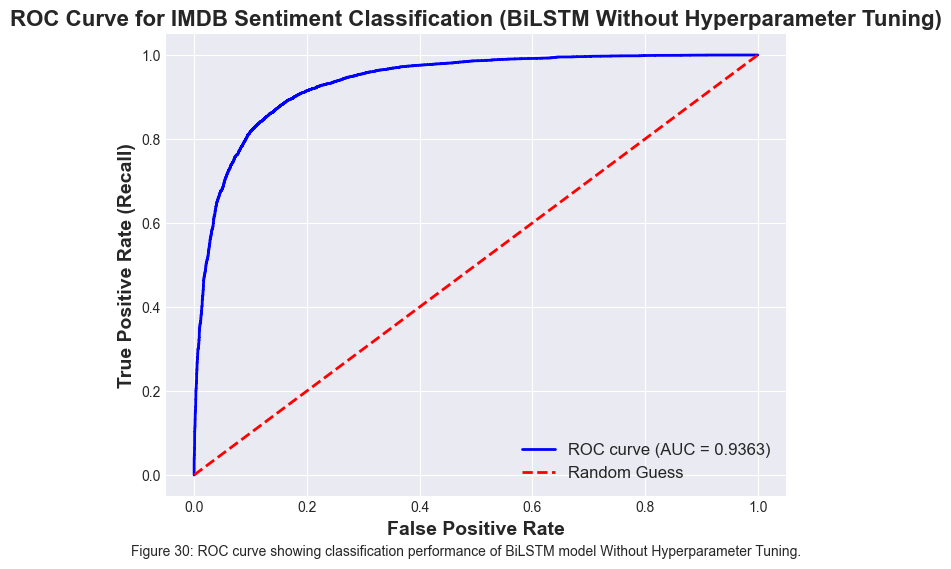

In [143]:
# ROC Curve Plotting
fpr, tpr, thresholds = roc_curve(ytest, ypred_no_hp_bilstm_probs)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {no_hp_bilstm_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
plt.title('ROC Curve for IMDB Sentiment Classification (BiLSTM Without Hyperparameter Tuning)', fontsize=16, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate (Recall)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.figtext(0.5, 0.01,
            "Figure 30: ROC curve showing classification performance of BiLSTM model Without Hyperparameter Tuning.",
            wrap=True, horizontalalignment='center', fontsize=10)
plt.savefig("roc_curve_no_hp_bilstm_imdb.png", dpi=300, bbox_inches='tight')
plt.show()

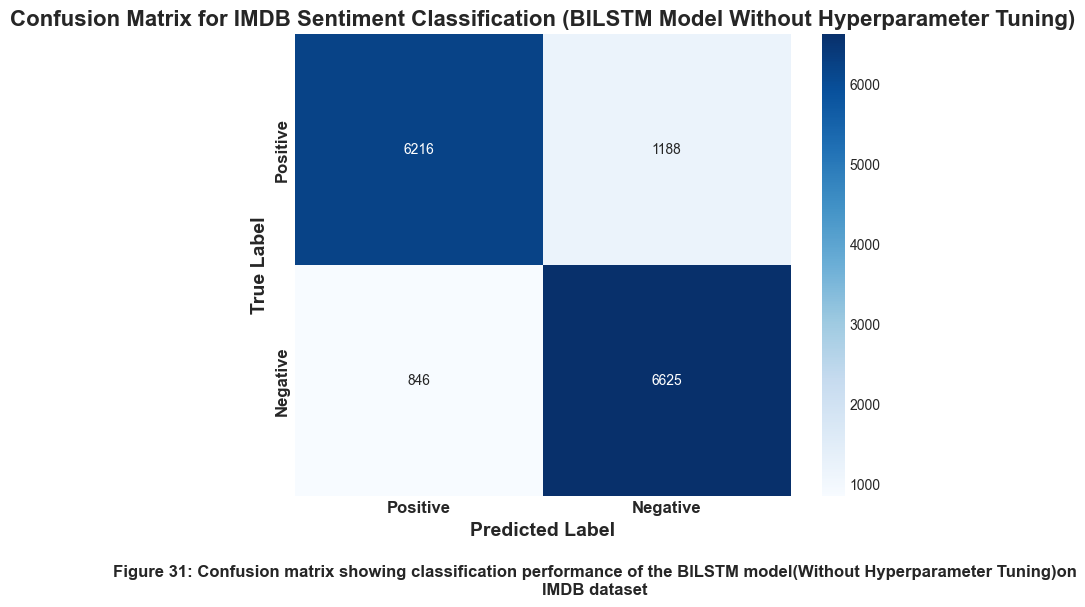

In [144]:
# Generating confusion matrix
no_hp_bilstm_cm = confusion_matrix(ytest, ypred_no_hp_bilstm, labels=[0, 1])   # ytest = true labels, ypred_no_hp_bilstm = predicted labels

plt.figure(figsize=(8,6))  # figure size

# Heatmap with bold colors
sns.heatmap(no_hp_bilstm_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Positive', 'Negative'],
            yticklabels=['Positive', 'Negative'])

# Adding bold title and labels
plt.title('Confusion Matrix for IMDB Sentiment Classification (BILSTM Model Without Hyperparameter Tuning)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')

# Making tick labels larger and bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 31: Confusion matrix showing classification performance of the BILSTM model(Without Hyperparameter Tuning)on IMDB dataset",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving plot with high resolution for reports
plt.savefig("confusion_matrix_no_hp_bilstmimdb.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [145]:
print("\nClassification Report for BILSTM Without Hyperparameter Tuning:\n")
print(classification_report(ytest, ypred_no_hp_bilstm, target_names=['Positive','Negative'], digits = 4))


Classification Report for BILSTM Without Hyperparameter Tuning:

              precision    recall  f1-score   support

    Positive     0.8802    0.8395    0.8594      7404
    Negative     0.8479    0.8868    0.8669      7471

    accuracy                         0.8633     14875
   macro avg     0.8641    0.8632    0.8632     14875
weighted avg     0.8640    0.8633    0.8632     14875



7aii. IMPLEMENTATION OF BIDIRECTIONAL LONG SHORT-TERM MEMORY MODEL(A TYPE OF RECURRENT NEURAL NETWORK ARCHITECTURE) WITH HYPERPARAMETER TUNING

In [146]:
# This function defines the BiLSTM architecture and accepts a HyperParameters object (hp)
def build_bilstm_model(hp):
    model = Sequential()
    
    # Embedding Layer - Exploring larger vector spaces
    embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=256, step=64)
    model.add(Embedding(input_dim=MAX_WORDS, output_dim=embedding_dim)) 
    
    # LSTM Layer - Adding a choice for recurrent dropout
    lstm_units = hp.Choice('lstm_units', values=[32, 64, 128])
    model.add(Bidirectional(LSTM(
        lstm_units, 
        return_sequences=False,
        recurrent_dropout=hp.Float('recurrent_dropout', 0.0, 0.3, step=0.1)
    )))
    
    # Dense Layer - Adding another fully connected layer before output
    if hp.Boolean('extra_dense_layer'):
        model.add(Dense(
            units=hp.Int('dense_units', 32, 128, step=32),
            activation=hp.Choice('dense_activation', ['relu', 'tanh'])
        ))
    
    # Dropout - Broadening the search range
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)
    model.add(Dropout(dropout_rate))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Optimizer Choice - Testing Adam versus RMSprop
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [147]:
# Defining the search strategy for the expanded model
tuner = kt.RandomSearch(
    build_bilstm_model,
    objective='val_accuracy',
    max_trials=10,           
    executions_per_trial=1,  # Number of models per trial 
    directory='keras_tuner_dir',
    project_name='bilstm_enhanced_tuning',
    overwrite=False           
)

Reloading Tuner from keras_tuner_dir\bilstm_enhanced_tuning\tuner0.json


In [148]:
# Printing the search space overview to confirm the new parameters
tuner.search_space_summary()

print("\nStarting Enhanced Keras Tuner Search...")

tuner.search(
    xtrain, 
    ytrain, 
    epochs=10, 
    batch_size=64, 
    validation_split=0.2,
    callbacks=[EarlyStopping('val_loss', patience=2)] # Helps speed up the search
)

Search space summary
Default search space size: 9
embedding_dim (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
lstm_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
recurrent_dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
extra_dense_layer (Boolean)
{'default': False, 'conditions': []}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.6, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop'], 'ordered': False}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0005, 0.0001], 'ordered': True}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 

In [149]:
#  Retrieving the top 3 best hyperparameter sets
top_hps = tuner.get_best_hyperparameters(num_trials=3)

results = []

for i, hp in enumerate(top_hps):
    # Extracting values based on the names defined in the build function
    results.append({
        "Rank": i + 1,
        "Embedding Dim": hp.get('embedding_dim'),
        "LSTM Units": hp.get('lstm_units'),
        "Dropout": round(hp.get('dropout_rate'), 2),
        "Optimizer": hp.get('optimizer'),
        "Learning Rate": hp.get('learning_rate'),
        "Extra Dense?": hp.get('extra_dense_layer'),
        "Recurrent Dropout": round(hp.get('recurrent_dropout'), 2)
    })

# Displaying as a DataFrame for easy reading
df_results = pd.DataFrame(results)
print("\nTop 3 Hyperparameter Configurations:")
print(df_results.to_string(index=False))

# Saving the table to a CSV 
df_results.to_csv("top_3_bilstm_configs.csv", index=False)


Top 3 Hyperparameter Configurations:
 Rank  Embedding Dim  LSTM Units  Dropout Optimizer  Learning Rate  Extra Dense?  Recurrent Dropout
    1            256         128      0.5      adam         0.0001         False                0.2
    2            256          64      0.5      adam         0.0001         False                0.0
    3            256          32      0.3      adam         0.0005          True                0.0


In [150]:
# Select the Rank 1 hyperparameters
best_hps = top_hps[0]

# Building the model with the Rank 1 hyperparameters
best_bilstm_model = tuner.hypermodel.build(best_hps)

In [151]:
# Defining the callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Perform the full final training
print("Starting final BiLSTM training with best Hyperparameter Tuning...")
history = best_bilstm_model.fit(
    xtrain, 
    ytrain,
    epochs=5,
    batch_size=32,
    validation_split=0.2,   # Using 20% of xtrain and ytrain data
    callbacks=[early_stop]
)

Starting final BiLSTM training with best Hyperparameter Tuning...
Epoch 1/5
868/868 ━━━━━━━━━━━━━━━━━━━━ 740s 845ms/step - accuracy: 0.7536 - loss: 0.5047 - val_accuracy: 0.8606 - val_loss: 0.3314
Epoch 2/5
868/868 ━━━━━━━━━━━━━━━━━━━━ 693s 798ms/step - accuracy: 0.8860 - loss: 0.2979 - val_accuracy: 0.8679 - val_loss: 0.3142
Epoch 3/5
868/868 ━━━━━━━━━━━━━━━━━━━━ 731s 843ms/step - accuracy: 0.9146 - loss: 0.2331 - val_accuracy: 0.8760 - val_loss: 0.3025
Epoch 4/5
868/868 ━━━━━━━━━━━━━━━━━━━━ 692s 798ms/step - accuracy: 0.9315 - loss: 0.1931 - val_accuracy: 0.8729 - val_loss: 0.3184
Epoch 5/5
868/868 ━━━━━━━━━━━━━━━━━━━━ 687s 792ms/step - accuracy: 0.9446 - loss: 0.1629 - val_accuracy: 0.8735 - val_loss: 0.3613


In [152]:
# Displaying the model summary
best_bilstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 172, 256)            │       5,120,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,543,493 (63.11 MB)

 Trainable params: 5,514,497 (21.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,028,996 (42.07 MB)

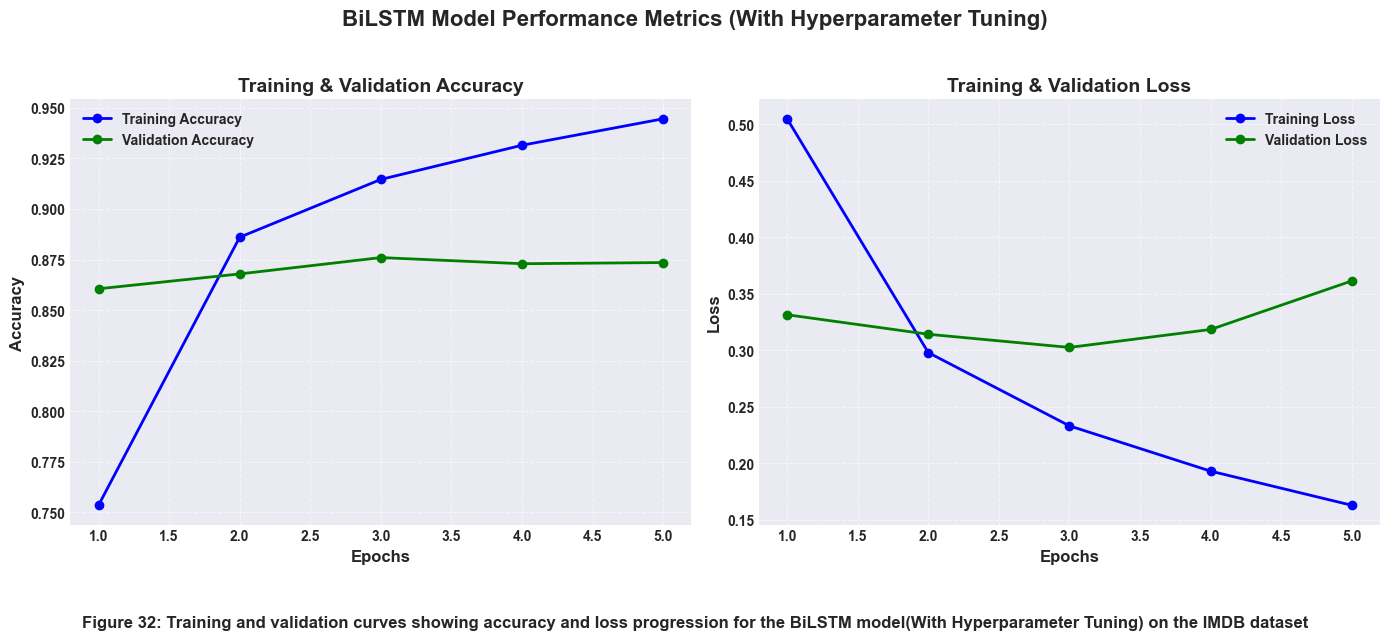

In [153]:
# Plotting the Training versus Validation Accuracy and Loss.This is the standard way to detect overfitting in Deep Learning.
def plot_history(history):
    # Extracting data from history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Setting up the figure size
    plt.figure(figsize=(14, 6))

    # Subplot 1: Accuracy 
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', linewidth=2, label='Training Accuracy')
    plt.plot(epochs, val_acc, 'go-', linewidth=2, label='Validation Accuracy')
    
    plt.title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
    plt.xticks(fontsize=10, fontweight='bold')
    plt.yticks(fontsize=10, fontweight='bold')
    plt.legend(prop={'weight': 'bold'})
    plt.grid(True, linestyle='--', alpha=0.6)

    # Subplot 2: Loss 
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', linewidth=2, label='Training Loss')
    plt.plot(epochs, val_loss, 'go-', linewidth=2, label='Validation Loss')
    
    plt.title('Training & Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12, fontweight='bold')
    plt.ylabel('Loss', fontsize=12, fontweight='bold')
    plt.xticks(fontsize=10, fontweight='bold')
    plt.yticks(fontsize=10, fontweight='bold')
    plt.legend(prop={'weight': 'bold'})
    plt.grid(True, linestyle='--', alpha=0.6)

    # Main Title for the entire figure
    plt.suptitle('BiLSTM Model Performance Metrics (With Hyperparameter Tuning)', fontsize=16, fontweight='bold')

    # Adding caption below the plot
    plt.figtext(0.5, -0.05, 
                "Figure 32: Training and validation curves showing accuracy and loss progression for the BiLSTM model(With Hyperparameter Tuning) on the IMDB dataset", 
                wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

    # Saving plot with high resolution for reports
    plt.savefig("bilstm_training_history.png", dpi=300, bbox_inches='tight')

    # Showing the plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjusting layout to make room for suptitle/caption
    plt.show()

# Executing the function
plot_history(history)

In [154]:
# Predictions using the best model
ypred_bilstm_probs = best_bilstm_model.predict(xtest).ravel()

465/465 ━━━━━━━━━━━━━━━━━━━━ 49s 104ms/step


In [155]:
# Converting probabilities to binary classes (Correct logic)
ypred_bilstm = (ypred_bilstm_probs >= 0.5).astype(int)

In [156]:
# Verifying the output
print(f"First 5 probabilities: {ypred_bilstm_probs[:5]}")
print(f"First 5 class predictions: {ypred_bilstm[:5]}")

First 5 probabilities: [0.00507992 0.93695116 0.913148   0.05957628 0.96158123]
First 5 class predictions: [0 1 1 0 1]


In [157]:
# Test Accuracy
bilstm_test_acc = best_bilstm_model.evaluate(xtest, ytest, verbose=0)[1]
print("\nTest Accuracy with Best Parameters for bilstm With Hyperparameter Tuning: {:.4f}".format(bilstm_test_acc))


Test Accuracy with Best Parameters for bilstm With Hyperparameter Tuning: 0.8719


In [158]:
# ROC-AUC 
bilstm_roc_auc = roc_auc_score(ytest, ypred_bilstm_probs) # which evaluates how well the model separates classes across thresholds
print("ROC-AUC for bilstm With Hyperparameter Tuning: {:.4f}".format(bilstm_roc_auc))

ROC-AUC for bilstm With Hyperparameter Tuning: 0.9444


In [159]:
# Log Loss 
bilstmlogloss = log_loss(ytest, ypred_bilstm_probs)
print("Log Loss for bilstm With Hyperparameter Tuning: {:.4f}".format(bilstmlogloss))

Log Loss for bilstm With Hyperparameter Tuning: 0.3097


In [160]:
# Precision
bilstmprecision = precision_score(ytest, ypred_bilstm)  # which measures how many predicted positives are truly positive
print("Precision for bilstm With Hyperparameter Tuning: {:.4f}".format(bilstmprecision))

Precision for bilstm With Hyperparameter Tuning: 0.8606


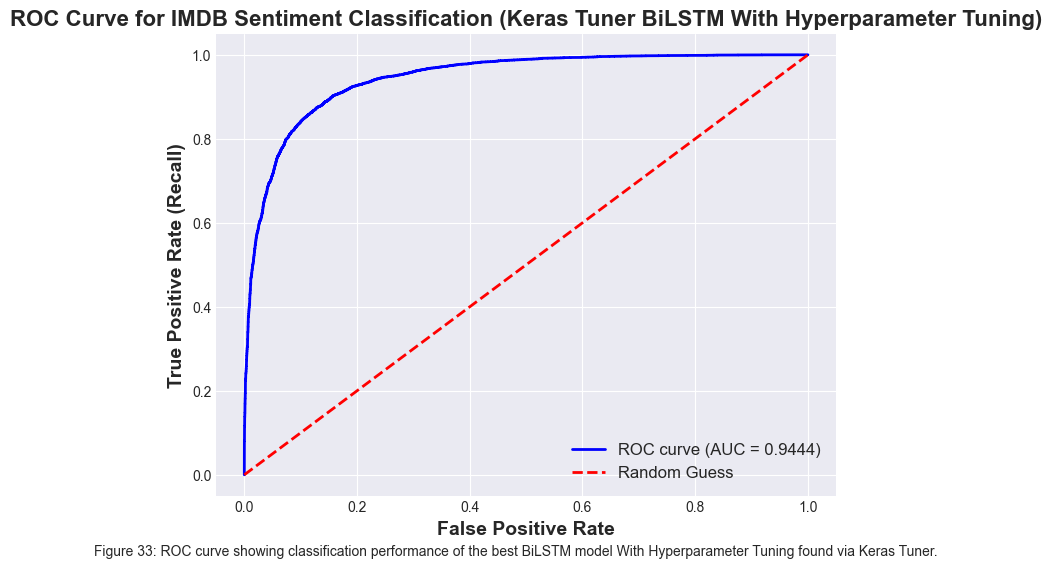

In [161]:
# ROC Curve Plotting
fpr, tpr, thresholds = roc_curve(ytest, ypred_bilstm_probs)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {bilstm_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
plt.title('ROC Curve for IMDB Sentiment Classification (Keras Tuner BiLSTM With Hyperparameter Tuning)', fontsize=16, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate (Recall)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.figtext(0.5, 0.01,
            "Figure 33: ROC curve showing classification performance of the best BiLSTM model With Hyperparameter Tuning found via Keras Tuner.",
            wrap=True, horizontalalignment='center', fontsize=10)
plt.savefig("roc_curve_bilstm_tuned_imdb_keras_tuner.png", dpi=300, bbox_inches='tight')
plt.show()

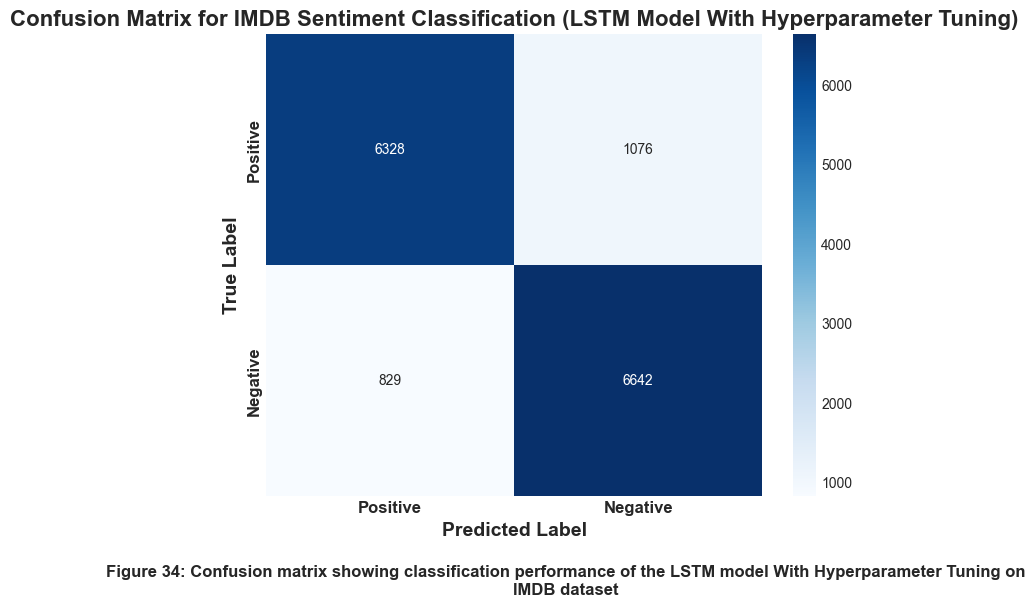

In [162]:
# Generating confusion matrix
bilstm_cm = confusion_matrix(ytest, ypred_bilstm, labels=[0, 1])   # ytest = true labels, ypred_bilstm = predicted labels

plt.figure(figsize=(8,6))  # figure size

# Heatmap with bold colors
sns.heatmap(bilstm_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Positive', 'Negative'],
            yticklabels=['Positive', 'Negative'])

# Adding bold title and labels
plt.title('Confusion Matrix for IMDB Sentiment Classification (LSTM Model With Hyperparameter Tuning)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')

# Making tick labels larger and bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 34: Confusion matrix showing classification performance of the LSTM model With Hyperparameter Tuning on IMDB dataset",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving plot with high resolution
plt.savefig("confusion_matrix_bilstm_imdb.png", dpi=300, bbox_inches='tight')

# Showing the plot
plt.show()

In [163]:
print("\nClassification Report (Best Model) for BILSTM With Hyperparameter Tuning:\n")
print(classification_report(ytest, ypred_bilstm, target_names=['Positive','Negative'], digits = 4))


Classification Report (Best Model) for BILSTM With Hyperparameter Tuning:

              precision    recall  f1-score   support

    Positive     0.8842    0.8547    0.8692      7404
    Negative     0.8606    0.8890    0.8746      7471

    accuracy                         0.8719     14875
   macro avg     0.8724    0.8719    0.8719     14875
weighted avg     0.8723    0.8719    0.8719     14875



7bi. DEEP LEARNING MODEL 2- IMPLEMENTATION OF TRANSFORMER(BERT) WITHOUT HYPERPARAMETER TUNING

In [164]:
# importing the requiredliraries
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import torch
import torch.nn as nn
from transformers import BertModel
import torch.optim as optim
from tqdm import tqdm

In [165]:
print(len(df_imdb['cleaned_review_string']))

49582


In [166]:
print(len(df_imdb['sentiment']))

49582


In [167]:
# Converting the initially cleaned IMDB Data  to Csv
df_imdb_clean = df_imdb[['cleaned_review_string', 'sentiment']]

# Exporting to CSV
df_imdb_clean.to_csv('imdb_cleaned_reviews.csv', index=False)

In [168]:
# viewing the first 5 records
df_imdb_clean.head()

cleaned_review_string sentiment
0  one of the other reviewers has mentioned that ...  positive
1  a wonderful little production the filming tech...  positive
2  i thought this was a wonderful way to spend ti...  positive
3  basically there s a family where a little boy ...  negative
4  petter mattei s love in the time of money is a...  positive

In [169]:
data = pd.read_csv(
    'imdb_cleaned_reviews.csv',
    usecols=["cleaned_review_string","sentiment"],
    na_values=['no info', '.']
)

# Select 10000 random rows from the entire dataset
subset_data = data.sample(n=10000, random_state=42)

# Then split as usual
train, test = train_test_split(subset_data, test_size=0.2, random_state=42)

print(f"Total subset size: {len(subset_data)}")
print(f"Training set size: {len(train)}")
print(f"Test set size: {len(test)}")

Total subset size: 10000
Training set size: 8000
Test set size: 2000


In [170]:
# Initializing the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class IMDBDataset(Dataset):
    def __init__(self, df):
        self.texts = df["cleaned_review_string"].tolist()
        self.labels = (df["sentiment"] == "positive").astype(int).tolist()

    def __len__(self):    # Returning the number of samples to allow PyTorch to know how many items are in the dataset 
        return len(self.labels)

    def __getitem__(self, idx): # To process one sample at a time
        encoding = tokenizer(   # Tokenizing the text correctly for PyTorch
            self.texts[idx],
            truncation=True,
            padding="max_length",  # Essential for batching
            max_length=256,         # BERT usually handles up to 512
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}  # Cleaning up the dictionary (remove the extra batch dimension)
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)   # Adding the label
        return item

In [171]:
# Creating the Train and Test Dataset 
train_ds = IMDBDataset(train)
test_ds = IMDBDataset(test)

# Creating Train and Test DataLoader
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=4)

In [172]:
# Defining BERT-Frozen Classifier to avoid retraining. 
# This is a transfer learning process. 
# I will fine-tuning here later

In [173]:
torch.cuda.is_available() # To check whether system has a CUDA‑capable NVIDIA GPU 

False

In [174]:
# Run model on cuda, if GPU exists on device, Otherwise use "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"

class BertFrozenClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # loading pretrained bert to load the full BERT encoder with pretrained weights
        self.bert = BertModel.from_pretrained("bert-base-uncased")

        # Freezing BERT weights,which will not update during training, only classifier layers learn 
        for param in self.bert.parameters():
            param.requires_grad = False

        # Classifier on top of CLS token
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 2)
        )

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # This ensures BERT is fast and memory efficient (does not compute gradients)
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            cls = outputs.last_hidden_state[:, 0, :]  # Extracting the CLS embedding


        return self.classifier(cls) # Ensures only classifier head is trained

In [175]:
# Model weights are moved to CPU on device
No_hp_BERT_model = BertFrozenClassifier().to(device)

In [176]:
optimizer = torch.optim.Adam(No_hp_BERT_model.parameters(), lr=1e-3) # Setup Optimizer
criterion = nn.CrossEntropyLoss()   # Setup Loss 

print(f"Starting training on {device}...")

No_hp_BERT_model.train()
for epoch in range(3):
    total_loss = 0
    for batch in train_loader:
        # Defining variables by pulling them from the batch dictionary
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        
        # Forward pass
        outputs = No_hp_BERT_model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")

Starting training on cpu...
Epoch 1 | Loss: 0.4867
Epoch 2 | Loss: 0.4353
Epoch 3 | Loss: 0.4241


In [177]:
# importing the library needed
import torch.nn.functional as F

# Setting model to evaluation mode
No_hp_BERT_model.eval()

ypred_no_hp_bert_probs = []
ypred_no_hp_bert = []

# Generating predictions
with torch.no_grad():
    for batch in test_loader:
        # Moving batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        # Getting raw outputs (logits)
        logits = No_hp_BERT_model(input_ids, attention_mask)
        
        # Converting logits to probabilities using Softmax
        # BERT output usually has 2 columns: [prob_neg, prob_pos]
        probs = F.softmax(logits, dim=1)
        
        # Extracting probability for the positive class (column 1)
        ypred_no_hp_bert_probs.extend(probs[:, 1].cpu().numpy())
        
        # Getting binary class (0 or 1) by picking the highest probability
        preds = torch.argmax(probs, dim=1)
        ypred_no_hp_bert.extend(preds.cpu().numpy())

# Converting lists to numpy arrays
ypred_no_hp_bert_probs = np.array(ypred_no_hp_bert_probs)
ypred_no_hp_bert = np.array(ypred_no_hp_bert)

# Verifying the output
print(f"First 5 probabilities (Positive Class): {ypred_no_hp_bert_probs[:5]}")
print(f"First 5 class predictions: {ypred_no_hp_bert[:5]}")

First 5 probabilities (Positive Class): [0.9514303 0.7742708 0.9109825 0.9977093 0.9174689]
First 5 class predictions: [1 1 1 1 1]


In [178]:
correct_preds = 0
total_samples = 0

# Iterating through test_loader without calculating gradients
with torch.no_grad():
    for batch in test_loader:
        # Moving batch to the same device as model
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = No_hp_BERT_model(input_ids, attention_mask)
        
        # Get predictions (highest logit index)
        _, predicted = torch.max(outputs, 1)
        
        # Accumulate counts
        total_samples += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

# Calculating final accuracy
no_hp_bert_test_acc = correct_preds / total_samples

# Printing
print("\nTest Accuracy for BERT Without Hyperparameter Tuning: {:.4f}".format(no_hp_bert_test_acc))


Test Accuracy for BERT Without Hyperparameter Tuning: 0.7775


In [179]:
# Ensuring I have the true labels from test dataset
# test_ds.labels contains the 0s and 1s for the test set
y_true = np.array(test_ds.labels)

# Calculating the ROC-AUC score 
# Using the probabilities of the positive class (column 1)
bert_no_hp_roc_auc = roc_auc_score(y_true, ypred_no_hp_bert_probs)

# Printing
print("ROC-AUC for BERT Without Hyperparameter Tuning: {:.4f}".format(bert_no_hp_roc_auc))

ROC-AUC for BERT Without Hyperparameter Tuning: 0.9036


In [180]:
# Calculating Log Loss
# log_loss compares the actual 0/1 labels to the probability of the positive class
bert_no_hp_log_loss = log_loss(y_true, ypred_no_hp_bert_probs)

# Printing
print("Log Loss for BERT Without Hyperparameter Tuning: {:.4f}".format(bert_no_hp_log_loss))

Log Loss for BERT Without Hyperparameter Tuning: 0.4682


In [181]:
# Calculating Precision
# This measures: True Positives / (True Positives + False Positives)
bert_no_hp_precision = precision_score(y_true, ypred_no_hp_bert)

# Printing
print("Precision for BERT Without Hyperparameter Tuning: {:.4f}".format(bert_no_hp_precision))

Precision for BERT Without Hyperparameter Tuning: 0.7134


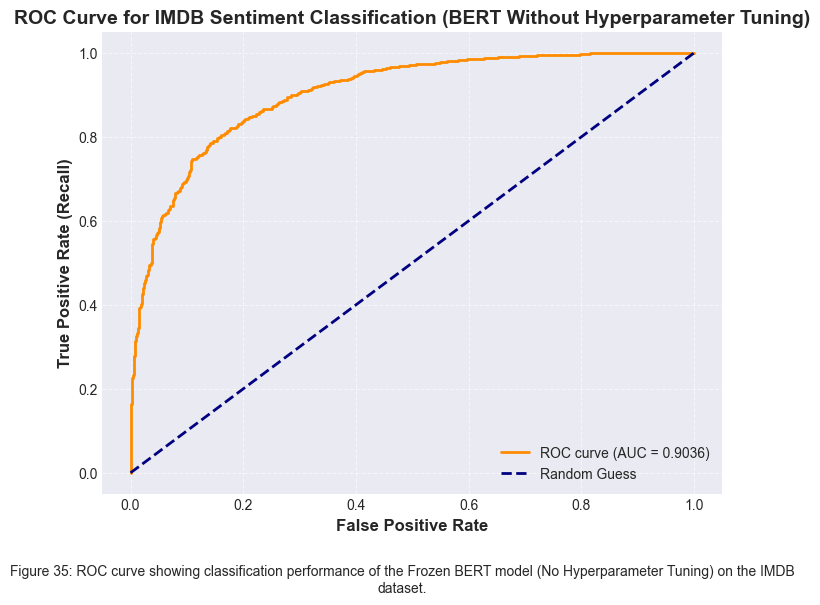

In [182]:
# Calculating FPR, TPR, and Thresholds for ROC CURVE
# y_true comes from test_ds.labels
# ypred_no_hp_bert_probs is the probability array for the positive class
fpr, tpr, thresholds = roc_curve(y_true, ypred_no_hp_bert_probs)

# Setup of the Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {bert_no_hp_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Formatting
plt.title('ROC Curve for IMDB Sentiment Classification (BERT Without Hyperparameter Tuning)', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Adding Caption and Saving
plt.figtext(0.5, -0.05, 
            "Figure 35: ROC curve showing classification performance of the Frozen BERT model (No Hyperparameter Tuning) on the IMDB dataset.", 
            wrap=True, horizontalalignment='center', fontsize=10)

plt.savefig("roc_curve_bert_no_hp_imdb.png", dpi=300, bbox_inches='tight')
plt.show()

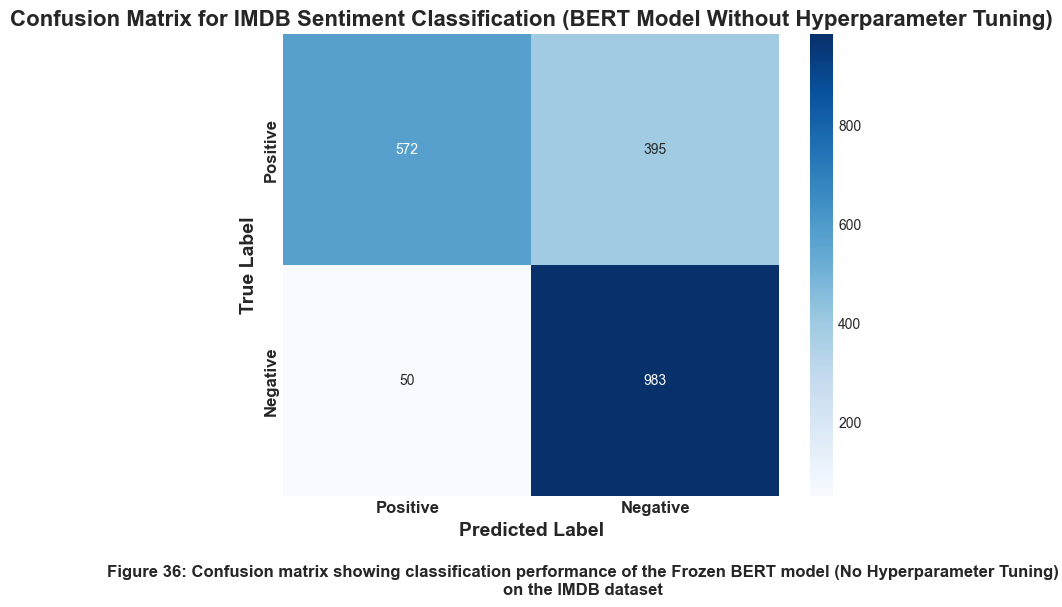

In [198]:
# Computing the confusion matrix
# y_true comes from test_ds.labels
# ypred_no_hp_bert are the binary (0 or 1) class predictions
no_hp_bert_cm = confusion_matrix(y_true, ypred_no_hp_bert, labels=[0, 1])

# Setup of the Plot
plt.figure(figsize=(8, 6))

# Heatmap with matching style
sns.heatmap(no_hp_bert_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Positive', 'Negative'], 
            yticklabels=['Positive', 'Negative'])

# Adding bold title and labels
plt.title('Confusion Matrix for IMDB Sentiment Classification (BERT Model Without Hyperparameter Tuning)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')

# Making tick labels larger and bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 36: Confusion matrix showing classification performance of the Frozen BERT model (No Hyperparameter Tuning) on the IMDB dataset",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# Saving and Showing
plt.savefig("confusion_matrix_bert_no_hp_imdb.png", dpi=300, bbox_inches='tight')
plt.show()

In [199]:
# y_true is the actual labels from test set
# ypred_no_hp_bert is the binary prediction array (0 and 1)
y_true = np.array(test_ds.labels)

# Printing
print("\nClassification Report for BERT Without Hyperparameter Tuning:\n")
print(classification_report(y_true, ypred_no_hp_bert, 
                            target_names=['Positive', 'Negative'], 
                            digits=4))


Classification Report for BERT Without Hyperparameter Tuning:

              precision    recall  f1-score   support

    Positive     0.9196    0.5915    0.7199       967
    Negative     0.7134    0.9516    0.8154      1033

    accuracy                         0.7775      2000
   macro avg     0.8165    0.7716    0.7677      2000
weighted avg     0.8131    0.7775    0.7693      2000



7bii. DEEP LEARNING MODEL 2- IMPLEMENTATION OF TRANSFORMER(BERT) WITH HYPERPARAMETER TUNING

In [200]:
 # This use Bayesian optimization to "guess" which parameters will work best based on previous trials.
!pip install optuna

In [186]:
class BertFrozenClassifierhp(nn.Module):
    def __init__(self, hidden_dim=256, dropout_rate=0.2):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")

        # Freezing BERT weights
        for param in self.bert.parameters():
            param.requires_grad = False

        # Tunable Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(768, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            cls = outputs.last_hidden_state[:, 0, :] 
        return self.classifier(cls)

In [187]:
# Model weights are moved to CPU on device
hp_BERT_model =  BertFrozenClassifierhp().to(device)

In [189]:
import optuna
from torch.utils.data import Subset
import numpy as np

In [192]:
# Creating a smaller subset for FAST tuning 
subset_indices = np.random.choice(len(train_ds), 8000, replace=False)
fast_train_subset = Subset(train_ds, subset_indices)

def objective(trial):
    # Search space to focus on the most impactful parameters for Frozen BERT
    lr = trial.suggest_float("lr", 5e-4, 5e-3, log=True)
    hidden_dim = trial.suggest_categorical("hidden_dim", [128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3)
    batch_size = 32 # Fixed batch size avoids the overhead of re-shuffling different sizes

    # Model Setup using hyperparameter tuning(HP)-ready class
    hp_BERT_model = BertFrozenClassifierhp(hidden_dim=hidden_dim, dropout_rate=dropout_rate).to(device)
    optimizer = torch.optim.Adam(hp_BERT_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Using the FAST subset for training
    fast_loader = DataLoader(fast_train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_ds, batch_size=batch_size)

    # Training
    # For frozen BERT, the classifier head adapts very quickly to the features
    hp_BERT_model.train()
    for batch in fast_loader:
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = hp_BERT_model(ids, mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation
    hp_BERT_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            if i > 20: break 
            ids, mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            outputs = hp_BERT_model(ids, mask)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    
    return correct / total

In [193]:
# Execution with Pruning
# MedianPruner will stop trials that are performing below the median of previous trials
study = optuna.create_study(
    direction="maximize", 
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=0)
)

print("Starting Fast Hyperparameter Tuning (5 Trials)...")
study.optimize(objective, n_trials=5)

print("\n" + "="*30)
print(f"Fast Tuning Complete!")
print(f"Best Accuracy on Subset: {study.best_value:.4f}")
print(f"Best Params: {study.best_params}")
print("="*30)

[I 2025-12-29 05:09:26,897] A new study created in memory with name: no-name-3e73e92d-33d2-4f20-a6b6-1963433b147d


Starting Fast Hyperparameter Tuning (5 Trials)...


[I 2025-12-29 06:55:41,342] Trial 0 finished with value: 0.8005952380952381 and parameters: {'lr': 0.0009172386438955556, 'hidden_dim': 128, 'dropout_rate': 0.1776025872988471}. Best is trial 0 with value: 0.8005952380952381.
[I 2025-12-29 08:41:51,299] Trial 1 finished with value: 0.7991071428571429 and parameters: {'lr': 0.0013226284939920493, 'hidden_dim': 128, 'dropout_rate': 0.2527868280316534}. Best is trial 0 with value: 0.8005952380952381.
[I 2025-12-29 10:28:01,219] Trial 2 finished with value: 0.7916666666666666 and parameters: {'lr': 0.0007600473811947786, 'hidden_dim': 128, 'dropout_rate': 0.13567695330744808}. Best is trial 0 with value: 0.8005952380952381.
[I 2025-12-29 12:13:57,812] Trial 3 finished with value: 0.8065476190476191 and parameters: {'lr': 0.0007938893072345333, 'hidden_dim': 256, 'dropout_rate': 0.2898841996208327}. Best is trial 3 with value: 0.8065476190476191.
[I 2025-12-29 13:59:36,210] Trial 4 finished with value: 0.7916666666666666 and parameters: {'l


Fast Tuning Complete!
Best Accuracy on Subset: 0.8065
Best Params: {'lr': 0.0007938893072345333, 'hidden_dim': 256, 'dropout_rate': 0.2898841996208327}


In [194]:
# Printing the best results
print("\n" + "="*30)
print("HYPERPARAMETER TUNING COMPLETE")
print(f"Best Trial Accuracy: {study.best_trial.value:.4f}")
print("Best Hyperparameters found:")
for key, value in study.best_params.items():
    print(f"  - {key}: {value}")
print("="*30)


HYPERPARAMETER TUNING COMPLETE
Best Trial Accuracy: 0.8065
Best Hyperparameters found:
  - lr: 0.0007938893072345333
  - hidden_dim: 256
  - dropout_rate: 0.2898841996208327


In [201]:
# Accessing the best parameters 
best_hparams = study.best_params

print("\n--- Training Final Model with Optimized Hyperparameters ---")
for key, value in best_hparams.items():
    print(f"{key}: {value}")

# Re-initializing the model using the optimized dimensions and dropout
final_hp_model = BertFrozenClassifierhp(
    hidden_dim=best_hparams['hidden_dim'], 
    dropout_rate=best_hparams['dropout_rate']
).to(device)

# Setting up Optimizer and DataLoaders with the optimized Learning Rate(lr) and Batch Size
optimizer = torch.optim.Adam(final_hp_model.parameters(), lr=best_hparams['lr'])
criterion = nn.CrossEntropyLoss()

final_train_loader = DataLoader(
    train_ds, 
    batch_size=32, 
    shuffle=True
)

# Final Training
final_hp_model.train()
for epoch in range(3):
    total_loss = 0
    for batch in final_train_loader:
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = final_hp_model(ids, mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Final Model - Epoch {epoch+1} | Loss: {total_loss/len(final_train_loader):.4f}")

# Saving the state dictionary of your best performing model
torch.save(final_hp_model.state_dict(), "best_tuned_bert_classifier.pth")
print("\nSuccess! Best model weights saved to 'best_tuned_bert_classifier.pth'.")


--- Training Final Model with Optimized Hyperparameters ---
lr: 0.0007938893072345333
hidden_dim: 256
dropout_rate: 0.2898841996208327
Final Model - Epoch 1 | Loss: 0.4928
Final Model - Epoch 2 | Loss: 0.4314
Final Model - Epoch 3 | Loss: 0.4168

Success! Best model weights saved to 'best_tuned_bert_classifier.pth'.


In [202]:
# Setting the optimized model to evaluation mode
final_hp_model.eval()

ypred_hp_bert_probs = []
ypred_hp_bert = []

# Generating predictions using the test_loader
with torch.no_grad():
    for batch in test_loader:
        # Moving batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        # Getting raw outputs (logits) from the optimized model
        logits = final_hp_model(input_ids, attention_mask)
        
        # Converting logits to probabilities using Softmax
        # BERT output usually has 2 columns: [prob_neg, prob_pos]
        probs = F.softmax(logits, dim=1)
        
        # Extracting probability for the positive class (column 1)
        ypred_hp_bert_probs.extend(probs[:, 1].cpu().numpy())
        
        # Getting binary class (0 or 1) by picking the highest probability
        preds = torch.argmax(probs, dim=1)
        ypred_hp_bert.extend(preds.cpu().numpy())

# Converting lists to numpy arrays
ypred_hp_bert_probs = np.array(ypred_hp_bert_probs)
ypred_hp_bert = np.array(ypred_hp_bert)

# Verifying the output
print(f"First 5 probabilities (Optimized Positive Class): {ypred_hp_bert_probs[:5]}")
print(f"First 5 class predictions (Optimized): {ypred_hp_bert[:5]}")

First 5 probabilities (Optimized Positive Class): [0.88222295 0.5455914  0.81523323 0.9949072  0.7385473 ]
First 5 class predictions (Optimized): [1 1 1 1 1]


In [203]:
correct_preds = 0
total_samples = 0

# Setting the optimized model to evaluation mode
final_hp_model.eval()

# Iterating through test_loader without calculating gradients
with torch.no_grad():
    for batch in test_loader:
        # Moving batch to the same device as model
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass using the final optimized model
        outputs = final_hp_model(input_ids, attention_mask)
        
        # Get predictions (highest logit index)
        _, predicted = torch.max(outputs, 1)
        
        # Accumulating counts
        total_samples += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

# Calculating final accuracy for the tuned model
hp_bert_test_acc = correct_preds / total_samples

# Printing the result
print("\nTest Accuracy for BERT With Hyperparameter Tuning: {:.4f}".format(hp_bert_test_acc))


Test Accuracy for BERT With Hyperparameter Tuning: 0.8245


In [204]:
# Ensuring I have the true labels from test dataset
# test_ds.labels contains the 0s and 1s for the test set
y_true = np.array(test_ds.labels)

# Calculating the ROC-AUC score for the tuned model
# Using the probabilities of the positive class (ypred_hp_bert_probs)
bert_hp_roc_auc = roc_auc_score(y_true, ypred_hp_bert_probs)

# Printing the results
print("ROC-AUC for BERT With Hyperparameter Tuning: {:.4f}".format(bert_hp_roc_auc))

ROC-AUC for BERT With Hyperparameter Tuning: 0.9078


In [205]:
# Calculating Log Loss for the tuned model
# log_loss compares the actual 0/1 labels to the probability of the positive class
bert_hp_log_loss = log_loss(y_true, ypred_hp_bert_probs)

# Printing
print("Log Loss for BERT With Hyperparameter Tuning: {:.4f}".format(bert_hp_log_loss))

Log Loss for BERT With Hyperparameter Tuning: 0.3870


In [206]:
# Calculating Precision for the tuned model
# This measures: True Positives / (True Positives + False Positives)
bert_hp_precision = precision_score(y_true, ypred_hp_bert)

# Printing the result
print("Precision for BERT With Hyperparameter Tuning: {:.4f}".format(bert_hp_precision))

Precision for BERT With Hyperparameter Tuning: 0.8199


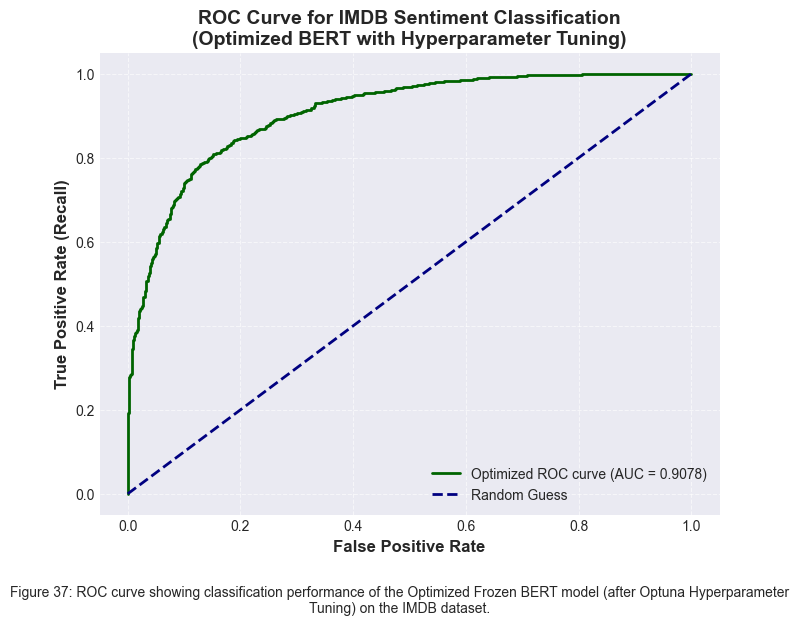

In [207]:
# Calculating FPR, TPR, and Thresholds For ROC CURVE
# Using probabilities of the positive class from the tuned model
fpr_hp, tpr_hp, thresholds_hp = roc_curve(y_true, ypred_hp_bert_probs)

# Setup of the Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_hp, tpr_hp, color='darkgreen', lw=2, 
         label=f'Optimized ROC curve (AUC = {bert_hp_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Formatting
plt.title('ROC Curve for IMDB Sentiment Classification\n(Optimized BERT with Hyperparameter Tuning)', 
          fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Adding Caption and Saving
plt.figtext(0.5, -0.05, 
            "Figure 37: ROC curve showing classification performance of the Optimized Frozen BERT model "
            "(after Optuna Hyperparameter Tuning) on the IMDB dataset.", 
            wrap=True, horizontalalignment='center', fontsize=10)

plt.savefig("roc_curve_bert_hp_tuned_imdb.png", dpi=300, bbox_inches='tight')
plt.show()

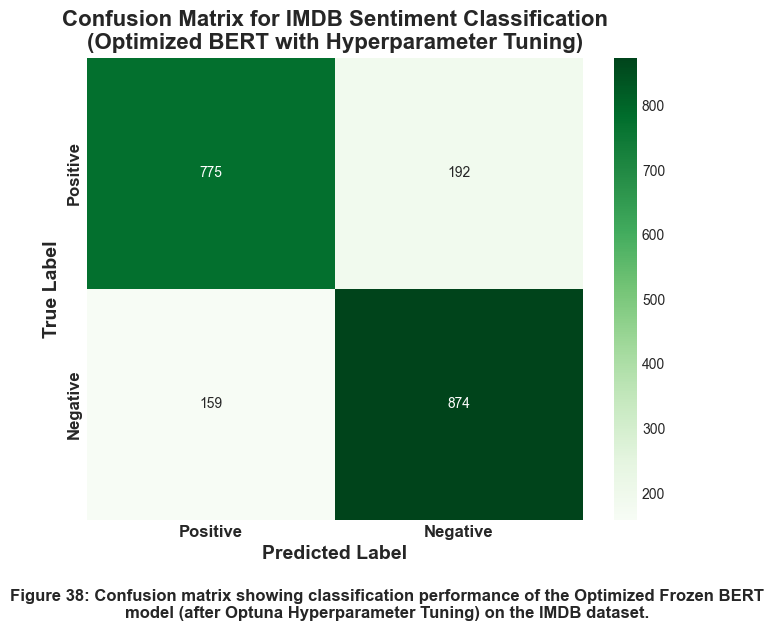

In [208]:
# Computing the confusion matrix for the optimized model
# y_true comes from test_ds.labels
# ypred_hp_bert are the binary predictions from the final tuned model
hp_bert_cm = confusion_matrix(y_true, ypred_hp_bert, labels=[0, 1])

# Setup of the Plot
plt.figure(figsize=(8, 6))

# Heatmap with matching style (Green theme to differentiate from base model)
sns.heatmap(hp_bert_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Positive', 'Negative'], 
            yticklabels=['Positive', 'Negative'])

# Adding bold title and labels
plt.title('Confusion Matrix for IMDB Sentiment Classification\n(Optimized BERT with Hyperparameter Tuning)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')

# Making tick labels larger and bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adding caption below the plot
plt.figtext(0.5, -0.05,
            "Figure 38: Confusion matrix showing classification performance of the Optimized Frozen BERT model "
            "(after Optuna Hyperparameter Tuning) on the IMDB dataset.",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

# 5. Saving and Showing
plt.savefig("confusion_matrix_bert_hp_tuned_imdb.png", dpi=300, bbox_inches='tight')
plt.show()

In [209]:
# Ensuring I have the true labels from  test set
y_true = np.array(test_ds.labels)

# Printing the report for the tuned model
print("\nClassification Report for BERT With Hyperparameter Tuning:\n")

# ypred_hp_bert are the binary predictions (0 and 1) from the final optimized model
print(classification_report(y_true, ypred_hp_bert, 
                            target_names=['Positive', 'Negative'], 
                            digits=4))


Classification Report for BERT With Hyperparameter Tuning:

              precision    recall  f1-score   support

    Positive     0.8298    0.8014    0.8154       967
    Negative     0.8199    0.8461    0.8328      1033

    accuracy                         0.8245      2000
   macro avg     0.8248    0.8238    0.8241      2000
weighted avg     0.8247    0.8245    0.8244      2000



8.COMPARISON OF THE MODELS

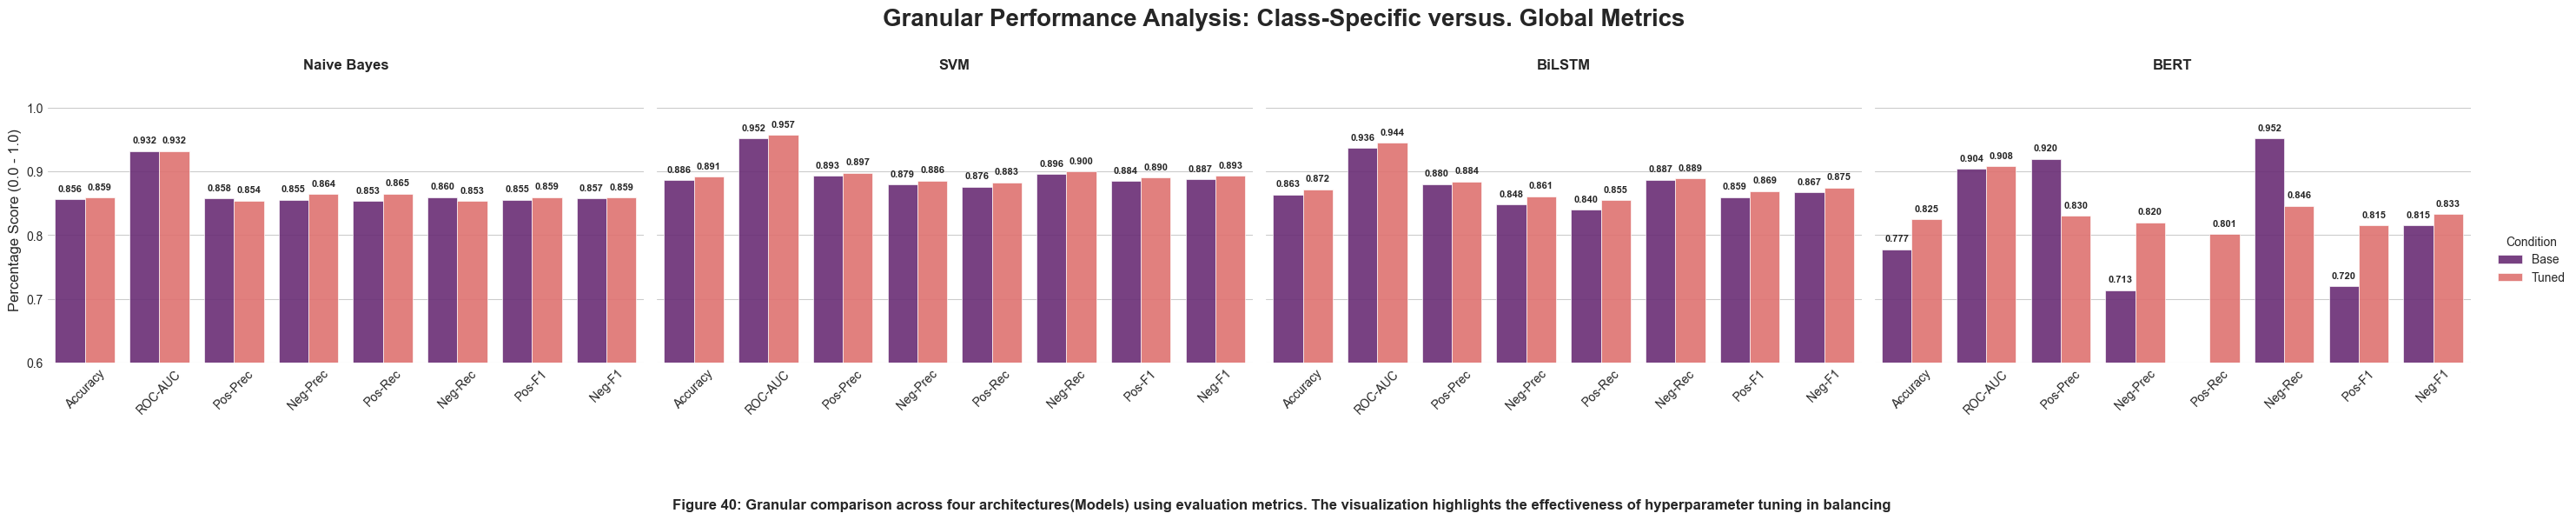

In [213]:
# Comprehensive Data representing all metrics to Compare the Models
# Pos = Positive Class / Neg = Negative Class
# Where "Base" means model implemented without refinement by hyperparameter tuning.
# Where "Tuned" means model implemented with refinement by hyperparameter tuning
# Where "Prec" = Precision
# Where "Rec" = Recall
# Where "Supp" = Support
# Where "F1" = F1-Score

Models_metrics_data = [
    {
        "Model": "Naive Bayes", "Condition": "Base", 
        "Accuracy": 0.8563, "ROC-AUC": 0.9318, "Log Loss": 0.4098,
        "Pos-Prec": 0.8575, "Neg-Prec": 0.8551, 
        "Pos-Rec": 0.8531, "Neg-Rec": 0.8595, 
        "Pos-F1": 0.8552, "Neg-F1": 0.8573,
        "Pos-Supp": 7404, "Neg-Supp": 7471
    },       
    {
        "Model": "Naive Bayes", "Condition": "Tuned", 
        "Accuracy": 0.8589, "ROC-AUC": 0.9318, "Log Loss": 0.4531,
        "Pos-Prec": 0.8537, "Neg-Prec": 0.8642, 
        "Pos-Rec": 0.8647, "Neg-Rec": 0.8532, 
        "Pos-F1": 0.8592, "Neg-F1": 0.8586,
        "Pos-Supp": 7404, "Neg-Supp": 7471
    },         
    {
        "Model": "SVM", "Condition": "Base", 
        "Accuracy": 0.8861, "ROC-AUC": 0.9518, "Log Loss": 0.2829,
        "Pos-Prec": 0.8931, "Neg-Prec": 0.8793, 
        "Pos-Rec": 0.8761, "Neg-Rec": 0.8959, 
        "Pos-F1": 0.8845, "Neg-F1": 0.8875,
        "Pos-Supp": 7410, "Neg-Supp": 7465
    },
    {
        "Model": "SVM", "Condition": "Tuned", 
        "Accuracy": 0.8914, "ROC-AUC": 0.9572, "Log Loss": 0.2683,
        "Pos-Prec": 0.8975, "Neg-Prec": 0.8856, 
        "Pos-Rec": 0.8829, "Neg-Rec": 0.8999, 
        "Pos-F1": 0.8901, "Neg-F1": 0.8927,
        "Pos-Supp": 7410, "Neg-Supp": 7465
    },
    {
        "Model": "BiLSTM", "Condition": "Base", 
        "Accuracy": 0.8633, "ROC-AUC": 0.9363, "Log Loss": 0.3241,
        "Pos-Prec": 0.8802, "Neg-Prec": 0.8479, 
        "Pos-Rec": 0.8395, "Neg-Rec": 0.8868, 
        "Pos-F1": 0.8594, "Neg-F1": 0.8669,
        "Pos-Supp": 7404, "Neg-Supp": 7471
    }, 
    {
        "Model": "BiLSTM", "Condition": "Tuned", 
        "Accuracy": 0.8719, "ROC-AUC": 0.9444, "Log Loss": 0.3097,
        "Pos-Prec": 0.8842, "Neg-Prec": 0.8606, 
        "Pos-Rec": 0.8547, "Neg-Rec": 0.8890, 
        "Pos-F1": 0.8692, "Neg-F1": 0.8746,
        "Pos-Supp": 7404, "Neg-Supp": 7471
    }, 
    {
        "Model": "BERT", "Condition": "Base", 
        "Accuracy": 0.7775, "ROC-AUC": 0.9036, "Log Loss": 0.4682,
        "Pos-Prec": 0.9196, "Neg-Prec": 0.7134, 
        "Pos-Rec": 0.5915, "Neg-Rec": 0.9516, 
        "Pos-F1": 0.7199, "Neg-F1": 0.8154,
        "Pos-Supp": 967, "Neg-Supp": 1033
    },
    {
        "Model": "BERT", "Condition": "Tuned", 
        "Accuracy": 0.8245, "ROC-AUC": 0.9078, "Log Loss": 0.3870,
        "Pos-Prec": 0.8298, "Neg-Prec": 0.8199, 
        "Pos-Rec": 0.8014, "Neg-Rec": 0.8461, 
        "Pos-F1": 0.8154, "Neg-F1": 0.8328,
        "Pos-Supp": 967, "Neg-Supp": 1033
    },
]

df_model_metrics = pd.DataFrame(Models_metrics_data)
df_model_metrics.to_csv('detailed_model_comparison_metrics.csv', index=False)

# Melting for visualization,filtering out Support and Log Loss for the plot to maintain scale
plot_metrics = ['Accuracy', 'ROC-AUC', 'Pos-Prec', 'Neg-Prec', 'Pos-Rec', 'Neg-Rec', 'Pos-F1', 'Neg-F1']
df_melted_model_metrics = df_model_metrics.melt(id_vars=['Model', 'Condition'], value_vars=plot_metrics, 
                    var_name='Metric', value_name='Value')

# Visualization Setup
sns.set_style("whitegrid")
g = sns.catplot(
    data=df_melted_model_metrics, kind="bar",
    x="Metric", y="Value", hue="Condition", col="Model",
    palette="magma", alpha=.9, height=6, aspect=1.2
)

# Styling and Labeling
g.set_axis_labels("", "Percentage Score (0.0 - 1.0)")
g.set_titles("{col_name}", fontweight='bold', fontsize=14)
g.despine(left=True)

# Adding Value Annotations on Bars
for ax in g.axes.flat:
    ax.set_ylim(0.6, 1.05) 
    ax.tick_params(axis='x', rotation=45)
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(format(p.get_height(), '.3f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 9), textcoords = 'offset points',
                           fontsize=8, fontweight='bold')

plt.subplots_adjust(top=0.85, bottom=0.3)
g.fig.suptitle('Granular Performance Analysis: Class-Specific versus. Global Metrics', fontsize=20, fontweight='bold')

# Adding Caption
plt.figtext(0.5, 0.02,
            "Figure 40: Granular comparison across four architectures(Models) using evaluation metrics. "
            "The visualization highlights the effectiveness of hyperparameter tuning in balancing ",
            wrap=True, horizontalalignment='center', fontsize=12, fontweight='bold')

plt.savefig('granular_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [217]:
df_model_metrics.style.set_caption("Detailed Model Comparison Metrics") # Table for Model Comparison Metrics